In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import os
import talos as ta
from talos.model.early_stopper import early_stopper
from sklearn.preprocessing import StandardScaler

%load_ext tensorboard
import tensorflow_addons as tfa
import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.metrics import Recall, Precision
import seaborn as sns

from sklearn.model_selection import train_test_split


import tensorflow as tf

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

In [2]:
train_df=pd.read_csv("C:/Users/Marze/OneDrive/Dokumenty/Jarek/Magisterka/Dane_do_uczenia_M.csv", encoding="utf-8")
del train_df['Unnamed: 0']

In [3]:
train_df.head()

,ENSG00000212232.1,ENSG00000238741.1,ENSG00000252481.1,ENSG00000239002.3,ENSG00000212443.1,ENSG00000274012.1,ENSG00000252010.1,ENSG00000202198.1,ENSG00000251791.1,ENSG00000202058.1,...,ENSG00000241475.1,ENSG00000274618.1,ENSG00000227293.1,ENSG00000253526.1,ENSG00000270654.1,ENSG00000271394.1,ENSG00000265423.1,ENSG00000253165.1,ENSG00000201901.1,scale
0,27.356617,31.768974,27.356617,5.294829,8.824715,6.645010e+02,2.647415,4.235863e+02,7.059772,16.766959,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,M0
1,8.695633,1.086954,6.521724,2.173908,0.000000,1.758692e+03,1.086954,5.434770e+01,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,M0
2,20.185177,77.002713,7.475992,4.485595,8.971190,2.775836e+03,2.242797,2.609121e+02,6.728392,10.466388,...,0.000000,0.747599,0.0,0.747599,0.0,0.747599,0.000000,0.0,0.000000,M0
3,18.157930,17.431612,6.536855,2.178952,2.905269,2.338741e+02,3.631586,6.827382e+01,1.452634,1.452634,...,0.726317,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,M0
4,29912.168049,21631.677176,9554.333460,20332.131551,5136.495208,1.255850e+06,19221.760289,1.926818e+06,5198.182500,2655.637935,...,0.000000,953.068666,0.0,20.562431,0.0,269.367843,64.771657,0.0,123.374585,M0


In [4]:
train_df['scale'].loc[(train_df['scale'] == 'M0')] = 0
train_df['scale'].loc[(train_df['scale'] == 'M1')] = 1

In [5]:
train_df=train_df.loc[(train_df['scale']!='MX')]

In [6]:
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42,stratify=train_df['scale'])
#test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42,stratify=test_df['scale'])


train_label=train_df['scale']
test_label=test_df['scale']
#val_label=val_df['scale']
del train_df['scale']
del test_df['scale']
#del val_df['scale']


In [7]:
len(list(train_df))

110

In [8]:
train_label.shape

(568,)

In [9]:
test_label.shape

(142,)

In [10]:
#val_label.shape

## 1.2 Standaryzacja

In [11]:
scaler = StandardScaler()
train_df=scaler.fit_transform(train_df)
test_df=scaler.fit_transform(test_df)
#val_df=scaler.fit_transform(val_df)


In [12]:
train_df

array([[-0.23532639, -0.28536286, -0.29189695, ..., -0.20273415,
        -0.13658188, -0.25716709],
       [-0.23488914, -0.28412701, -0.28766847, ..., -0.20273415,
        -0.13658188, -0.25716709],
       [-0.23513615, -0.28194648, -0.28119849, ..., -0.1127296 ,
        -0.13658188, -0.18291094],
       ...,
       [-0.23560858, -0.28411483, -0.29158105, ..., -0.20273415,
        -0.07110588, -0.25716709],
       [13.92769305,  3.11477926,  6.81130447, ..., -0.05473062,
        -0.13658188,  1.2895196 ],
       [-0.23495945, -0.28021459, -0.28164044, ..., -0.20273415,
        -0.07405669, -0.25716709]])

In [13]:
train_df.shape

(568, 110)

In [14]:
train_label=np.asarray(train_label).astype(np.int)
test_label=np.asarray(test_label).astype(np.int)
#val_label=np.asarray(val_label).astype(np.int)

In [15]:
train_label

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [16]:
train_label.shape

(568,)

In [17]:
train_label=train_label.reshape(-1,1)
test_label=test_label.reshape(-1,1)
#val_label=val_label.reshape(-1,1)

In [18]:
test_label.shape

(142, 1)

# 2 Moduł TALOS

## 2.1 Słownik parametrów do wypróbowania

In [19]:
## Dobor Gammy i alfy

In [69]:
p = {
    'first_neuron':[55,110,220], 
     'hidden_neuron':[50,100,150],

     'hidden_layers':[1,3,5,7,9],  

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [32],

    'lr':[0.001],
    
    'kernel_regularizer_l1':[0.0001],#[0,0.001,0.0001],
    'kernel_regularizer_l2':[0.0001],#[0,0.001,0.0001],
    'bias_regularizer':[0.0001],#[0,0.001,0.0001],
    'activity_regularizer':[0.0001],#[0,0.001,0.0001],

#    'batc_normalization':[False,True],
#    'dropout': [0,0.2,0.4],
    'dropout': [0],
    
    'optimizer': ['rmsprop','adam','adadelta','adamax','nadam','adagrad'],
    #'kernel_initializer': ['orthogonal','identity','zeros','ones','uniform'],
    'kernel_initializer': ['orthogonal'],
    #'activation_layer':['sigmoid','tanh','selu','elu','relu'],
    'activation_layer':['relu'],
    #'batc_normalization':[False,True]
    'batc_normalization':[False],

    
}

## 2.22 Weights for classes

In [32]:
# Calculate the weights for each class so that we can balance the data
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(train_label),
                                            y=train_label.ravel())

In [33]:
weights

array([0.58921162, 3.30232558])

In [68]:

def numerai_model(x_train, y_train, x_val, y_val, params):
    
    print(params)

    model = Sequential()
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
               
                    kernel_initializer = params['kernel_initializer'],
                    kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    if params['batc_normalization']==True:
        model.add(BatchNormalization())
        
    if params['dropout']!=0:
        model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer'],
                        kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                    l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                       ))
        if params['batc_normalization']==True:
            model.add(BatchNormalization())
            
        if params['dropout']!=0:
            model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer'],
                   kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                               l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=params['optimizer'],
                  #tf.keras.optimizers.Adamax(learning_rate=params['lr']),
                  metrics=[tfa.metrics.FBetaScore(num_classes=1, beta=1.0, threshold=0.5),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),])
    
  
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0,
                        class_weight={0 : 0.58921162,
                                      1 : 3.30232558},
                        callbacks = [
                                     EarlyStopping(monitor='val_loss',
                                        min_delta=0.01,
                                        patience=50, mode='min',verbose=1,
                                                      restore_best_weights=True)
                                    ] #,ta.live(),
                        )

    return history, model

In [52]:
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(train_label),
                                            y=train_label.ravel())

In [53]:
weights

array([0.58921162, 3.30232558])

## 2.3 Przeprowadzam skan, używając parametrów i funkcji wyżej


##  3. Part 1

In [70]:

t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy M - Weighted binary cross-entropy (nowe)')

Restoring model weights from the end of the best epoch: 1.
Epoch 00051: early stopping


 88%|██████████████████████████████████████████████████████████████████████▏         | 237/270 [42:07<05:39, 10.30s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object 

 88%|██████████████████████████████████████████████████████████████████████▌         | 238/270 [42:23<06:29, 12.17s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object h

 89%|██████████████████████████████████████████████████████████████████████▊         | 239/270 [42:35<06:16, 12.13s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object

 89%|███████████████████████████████████████████████████████████████████████         | 240/270 [42:43<05:24, 10.81s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 7, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' objec

 89%|███████████████████████████████████████████████████████████████████████▍        | 241/270 [42:51<04:53, 10.11s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 7, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object h

 90%|███████████████████████████████████████████████████████████████████████▋        | 242/270 [43:06<05:20, 11.45s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 7, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' obje

 90%|████████████████████████████████████████████████████████████████████████        | 243/270 [43:13<04:33, 10.12s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 7, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object

 90%|████████████████████████████████████████████████████████████████████████▎       | 244/270 [43:28<04:57, 11.44s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 7, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object 

 91%|████████████████████████████████████████████████████████████████████████▌       | 245/270 [43:40<04:57, 11.88s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 7, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' objec

 91%|████████████████████████████████████████████████████████████████████████▉       | 246/270 [43:47<04:08, 10.35s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 7, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' objec

 91%|█████████████████████████████████████████████████████████████████████████▏      | 247/270 [43:59<04:10, 10.91s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 7, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object h

 92%|█████████████████████████████████████████████████████████████████████████▍      | 248/270 [44:14<04:27, 12.14s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 7, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' obje

 92%|█████████████████████████████████████████████████████████████████████████▊      | 249/270 [44:22<03:47, 10.81s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 7, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object

 93%|██████████████████████████████████████████████████████████████████████████      | 250/270 [44:40<04:18, 12.90s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 7, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object 

 93%|██████████████████████████████████████████████████████████████████████████▎     | 251/270 [44:54<04:12, 13.29s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 7, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' objec

 93%|██████████████████████████████████████████████████████████████████████████▋     | 252/270 [45:36<06:32, 21.79s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full out

 94%|██████████████████████████████████████████████████████████████████████████▉     | 253/270 [45:45<05:05, 17.95s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output

 94%|███████████████████████████████████████████████████████████████████████████▎    | 254/270 [45:53<03:59, 14.97s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full ou

 94%|███████████████████████████████████████████████████████████████████████████▌    | 255/270 [46:00<03:09, 12.62s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outp

 95%|███████████████████████████████████████████████████████████████████████████▊    | 256/270 [46:12<02:54, 12.48s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outpu

 95%|████████████████████████████████████████████████████████████████████████████▏   | 257/270 [46:23<02:34, 11.92s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full out

 96%|████████████████████████████████████████████████████████████████████████████▍   | 258/270 [46:30<02:04, 10.40s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full ou

 96%|████████████████████████████████████████████████████████████████████████████▋   | 259/270 [46:40<01:55, 10.50s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outpu

 96%|█████████████████████████████████████████████████████████████████████████████   | 260/270 [46:53<01:51, 11.12s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full o

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 261/270 [47:01<01:31, 10.14s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full out

 97%|█████████████████████████████████████████████████████████████████████████████▋  | 262/270 [47:20<01:42, 12.87s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outp

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 263/270 [47:35<01:33, 13.39s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full ou

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 264/270 [47:46<01:16, 12.71s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full ou

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 265/270 [47:58<01:03, 12.62s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outpu

 99%|██████████████████████████████████████████████████████████████████████████████▊ | 266/270 [48:16<00:56, 14.13s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full o

 99%|███████████████████████████████████████████████████████████████████████████████ | 267/270 [48:25<00:37, 12.55s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full out

 99%|███████████████████████████████████████████████████████████████████████████████▍| 268/270 [48:47<00:30, 15.46s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outp

100%|███████████████████████████████████████████████████████████████████████████████▋| 269/270 [49:05<00:16, 16.34s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full ou

100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [50:12<00:00, 11.16s/it]


In [133]:
df = pd.read_csv('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/M/Predykcja klasy M - Weighted binary cross-entropy (nowe)/050622223819.csv')

In [134]:
stare_wart=df['val_fbeta_score']
nowe_wart=[]
for x in stare_wart:
    wart=x.replace('[','')
    wart=wart.replace(']','')
    wart=float(wart)
    nowe_wart.append(wart)

In [135]:
nowe_wart

[0.32352942,
 0.33333334,
 0.0,
 0.32432434,
 0.37837836,
 0.2769231,
 0.4,
 0.19354838,
 0.25974026,
 0.3157895,
 0.32432434,
 0.27480918,
 0.29752067,
 0.1764706,
 0.0,
 0.3888889,
 0.3380282,
 0.27480918,
 0.23529413,
 0.35897437,
 0.2531646,
 0.38095242,
 0.43243244,
 0.26470587,
 0.3,
 0.18750001,
 0.19047621,
 0.34146345,
 0.25742576,
 0.25196853,
 0.18750001,
 0.35897437,
 0.3007519,
 0.32432434,
 0.38095242,
 0.27906978,
 0.23529413,
 0.30769232,
 0.26829267,
 0.29411766,
 0.35897437,
 0.2769231,
 0.18750001,
 0.3111111,
 0.0,
 0.3137255,
 0.27027026,
 0.2635659,
 0.296875,
 0.3157895,
 0.125,
 0.3157895,
 0.29411766,
 0.2769231,
 0.30769232,
 0.29230767,
 0.26993865,
 0.25,
 0.29268292,
 0.2769231,
 0.27777776,
 0.29007635,
 0.0,
 0.22857143,
 0.24489795,
 0.27067667,
 0.2608696,
 0.28368795,
 0.25925925,
 0.13333334,
 0.29370627,
 0.2769231,
 0.2797203,
 0.2781457,
 0.28025478,
 0.28571427,
 0.28965515,
 0.27692306,
 0.2797203,
 0.28571427,
 0.0,
 0.2857143,
 0.28965515,
 0.2

In [136]:
df['val_fbeta_score']=nowe_wart

In [137]:
df=df.sort_values('val_loss',ascending=True)

In [138]:
df.columns

Index(['round_epochs', 'loss', 'fbeta_score', 'precision', 'recall',
       'val_loss', 'val_fbeta_score', 'val_precision', 'val_recall',
       'activation_layer', 'activity_regularizer', 'batc_normalization',
       'batch_size', 'bias_regularizer', 'dropout', 'epochs', 'first_neuron',
       'hidden_layers', 'hidden_neuron', 'kernel_initializer',
       'kernel_regularizer_l1', 'kernel_regularizer_l2', 'last_activation',
       'lr', 'optimizer'],
      dtype='object')

In [139]:
df

,round_epochs,loss,fbeta_score,precision,recall,val_loss,val_fbeta_score,val_precision,val_recall,activation_layer,...,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr,optimizer
81,256,0.590018,[0.45070425],0.323232,0.744186,0.532891,0.285714,0.384615,0.227273,relu,...,100000,55,9,100,orthogonal,0.0001,0.0001,sigmoid,0.001,adamax
7,115,0.587497,[0.3542857],0.234848,0.720930,0.575804,0.193548,0.333333,0.136364,relu,...,100000,55,1,100,orthogonal,0.0001,0.0001,sigmoid,0.001,adam
3,257,0.579288,[0.44660196],0.309417,0.802326,0.584282,0.324324,0.400000,0.272727,relu,...,100000,55,1,50,orthogonal,0.0001,0.0001,sigmoid,0.001,adamax
115,267,0.532578,[0.47142857],0.340206,0.767442,0.584678,0.368421,0.437500,0.318182,relu,...,100000,110,3,100,orthogonal,0.0001,0.0001,sigmoid,0.001,adam
171,192,0.652091,[0.42105263],0.276364,0.883721,0.586155,0.312500,0.500000,0.227273,relu,...,100000,110,9,100,orthogonal,0.0001,0.0001,sigmoid,0.001,adamax
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,51,2.096005,[0.2883895],0.171875,0.895349,2.093452,0.276923,0.166667,0.818182,relu,...,100000,55,9,150,orthogonal,0.0001,0.0001,sigmoid,0.001,adagrad
86,51,2.102069,[0.27213112],0.158397,0.965116,2.102681,0.263889,0.155738,0.863636,relu,...,100000,55,9,150,orthogonal,0.0001,0.0001,sigmoid,0.001,adadelta
269,717,2.128711,[0.3218391],0.192661,0.976744,2.135359,0.243902,0.166667,0.454545,relu,...,100000,220,9,150,orthogonal,0.0001,0.0001,sigmoid,0.001,adagrad
176,51,2.217879,[0.02247191],0.333333,0.011628,2.214797,0.000000,0.000000,0.000000,relu,...,100000,110,9,150,orthogonal,0.0001,0.0001,sigmoid,0.001,adadelta


Text(0.5, 1.0, 'Validation Loss as function of hidden_layers')

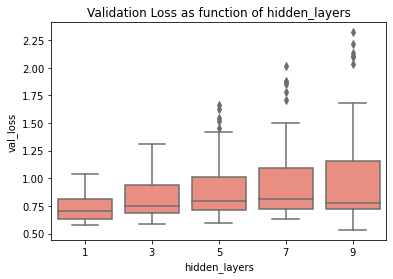

In [141]:
metric = 'hidden_layers'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


Text(0.5, 1.0, 'Validation Loss as function of hidden_neuron')

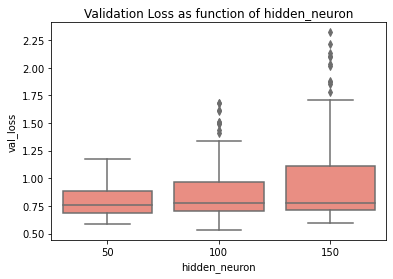

In [142]:
metric = 'hidden_neuron'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


Text(0.5, 1.0, 'Validation Loss as function of first_neuron')

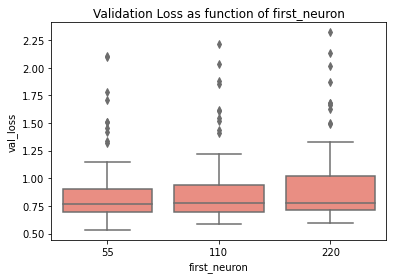

In [143]:
metric = 'first_neuron'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


Text(0.5, 1.0, 'Validation Loss as function of optimizer')

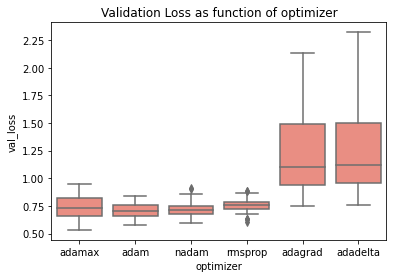

In [144]:
metric = 'optimizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


In [145]:
df2=df[df['optimizer']!='adagrad']

In [146]:
df2=df2[df2['optimizer']!='adadelta']

Text(0.5, 1.0, 'Validation Loss as function of optimizer')

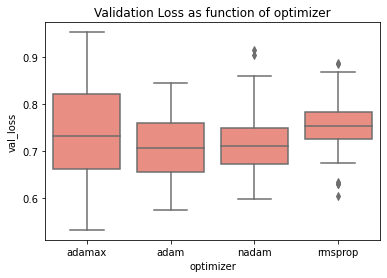

In [147]:
metric = 'optimizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df2.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

## Part 2

In [20]:

def numerai_model(x_train, y_train, x_val, y_val, params):
    
    print(params)

    model = Sequential()
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
               
                    kernel_initializer = params['kernel_initializer'],
                    kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    if params['batc_normalization']==True:
        model.add(BatchNormalization())
        
    if params['dropout']!=0:
        model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer'],
                        kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                    l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                       ))
        if params['batc_normalization']==True:
            model.add(BatchNormalization())
            
        if params['dropout']!=0:
            model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer'],
                   kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                               l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    
    model.compile(loss='binary_crossentropy',

                  optimizer=tf.keras.optimizers.Adam(learning_rate=params['lr']),
                  metrics=[tfa.metrics.FBetaScore(num_classes=1, beta=1.0, threshold=0.5),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),])
  
  
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0,
                        class_weight={0 : 0.58921162,
                                      1 : 3.30232558},
                        callbacks = [
                                     EarlyStopping(monitor='val_loss',
                                        min_delta=0.01,
                                        patience=50, mode='min',verbose=1,
                                                      restore_best_weights=True)
                                    ] #,ta.live(),
                        )

    return history, model

In [94]:
p = {
    'first_neuron':[55],  #Done
     'hidden_neuron':[50], #Done

     'hidden_layers':[1,2,3],  

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [16,32,64],

    'lr':[0.001],
    
    'kernel_regularizer_l1':[0.0001],#[0,0.001,0.0001],
    'kernel_regularizer_l2':[0.0001],#[0,0.001,0.0001],
    'bias_regularizer':[0.0001],#[0,0.001,0.0001],
    'activity_regularizer':[0.0001],#[0,0.001,0.0001],

#    'batc_normalization':[False,True],
    'dropout': [0,0.2,0.4],
  #  'dropout': [0],
    
  
    #'kernel_initializer': ['orthogonal','identity','zeros','ones','uniform'],
    'kernel_initializer': ['orthogonal'],
    #'activation_layer':['sigmoid','tanh','selu','elu','relu'],
    #'activation_layer':['relu'],
    'batc_normalization':[False,True]
    #'batc_normalization':[False],

}

In [95]:
t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy M - Weighted binary cross-entropy (nowe)')

  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model w

  2%|█▌                                                                                 | 1/54 [00:13<11:59, 13.58s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Re

  4%|███                                                                                | 2/54 [00:28<12:20, 14.23s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do

  6%|████▌                                                                              | 3/54 [00:37<10:10, 11.97s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model

  7%|██████▏                                                                            | 4/54 [00:49<09:51, 11.83s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


  9%|███████▋                                                                           | 5/54 [01:07<11:30, 14.08s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.

 11%|█████████▏                                                                         | 6/54 [01:25<12:25, 15.53s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model

 13%|██████████▊                                                                        | 7/54 [01:33<10:20, 13.20s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


 15%|████████████▎                                                                      | 8/54 [01:42<08:57, 11.68s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.

 17%|█████████████▊                                                                     | 9/54 [01:53<08:39, 11.54s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model w

 19%|███████████████▏                                                                  | 10/54 [02:02<07:57, 10.85s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Re

 20%|████████████████▋                                                                 | 11/54 [02:13<07:42, 10.75s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do

 22%|██████████████████▏                                                               | 12/54 [02:24<07:36, 10.88s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model

 24%|███████████████████▋                                                              | 13/54 [02:32<06:43,  9.85s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


 26%|█████████████████████▎                                                            | 14/54 [02:38<05:50,  8.76s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.

 28%|██████████████████████▊                                                           | 15/54 [02:48<06:01,  9.27s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model

 30%|████████████████████████▎                                                         | 16/54 [02:54<05:14,  8.29s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


 31%|█████████████████████████▊                                                        | 17/54 [03:03<05:06,  8.28s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.

 33%|███████████████████████████▎                                                      | 18/54 [03:13<05:18,  8.86s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model w

 35%|████████████████████████████▊                                                     | 19/54 [03:21<04:59,  8.57s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Re

 37%|██████████████████████████████▎                                                   | 20/54 [03:28<04:42,  8.31s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do

 39%|███████████████████████████████▉                                                  | 21/54 [03:36<04:26,  8.07s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model

 41%|█████████████████████████████████▍                                                | 22/54 [03:44<04:18,  8.09s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


 43%|██████████████████████████████████▉                                               | 23/54 [03:53<04:19,  8.37s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.

 44%|████████████████████████████████████▍                                             | 24/54 [04:02<04:18,  8.61s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model

 46%|█████████████████████████████████████▉                                            | 25/54 [04:07<03:37,  7.48s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


 48%|███████████████████████████████████████▍                                          | 26/54 [04:13<03:17,  7.06s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.

 50%|█████████████████████████████████████████                                         | 27/54 [04:22<03:24,  7.59s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model we

 52%|██████████████████████████████████████████▌                                       | 28/54 [04:32<03:35,  8.28s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Res

 54%|████████████████████████████████████████████                                      | 29/54 [04:40<03:29,  8.37s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 56%|█████████████████████████████████████████████▌                                    | 30/54 [04:51<03:36,  9.00s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model 

 57%|███████████████████████████████████████████████                                   | 31/54 [05:00<03:25,  8.91s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
R

 59%|████████████████████████████████████████████████▌                                 | 32/54 [05:10<03:27,  9.44s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.d

 61%|██████████████████████████████████████████████████                                | 33/54 [05:27<04:04, 11.64s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model 

 63%|███████████████████████████████████████████████████▋                              | 34/54 [05:38<03:48, 11.43s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
R

 65%|█████████████████████████████████████████████████████▏                            | 35/54 [05:46<03:17, 10.38s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.d

 67%|██████████████████████████████████████████████████████▋                           | 36/54 [05:55<03:01, 10.08s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model we

 69%|████████████████████████████████████████████████████████▏                         | 37/54 [06:03<02:37,  9.29s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Res

 70%|█████████████████████████████████████████████████████████▋                        | 38/54 [06:11<02:21,  8.84s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 72%|███████████████████████████████████████████████████████████▏                      | 39/54 [06:19<02:12,  8.84s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model 

 74%|████████████████████████████████████████████████████████████▋                     | 40/54 [06:29<02:08,  9.18s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
R

 76%|██████████████████████████████████████████████████████████████▎                   | 41/54 [06:41<02:08,  9.85s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.d

 78%|███████████████████████████████████████████████████████████████▊                  | 42/54 [06:53<02:06, 10.52s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model 

 80%|█████████████████████████████████████████████████████████████████▎                | 43/54 [07:08<02:11, 11.94s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
R

 81%|██████████████████████████████████████████████████████████████████▊               | 44/54 [07:18<01:54, 11.41s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.d

 83%|████████████████████████████████████████████████████████████████████▎             | 45/54 [07:26<01:31, 10.18s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model we

 85%|█████████████████████████████████████████████████████████████████████▊            | 46/54 [07:32<01:11,  8.89s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Res

 87%|███████████████████████████████████████████████████████████████████████▎          | 47/54 [07:38<00:58,  8.29s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 89%|████████████████████████████████████████████████████████████████████████▉         | 48/54 [07:46<00:48,  8.00s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model 

 91%|██████████████████████████████████████████████████████████████████████████▍       | 49/54 [07:53<00:38,  7.76s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
R

 93%|███████████████████████████████████████████████████████████████████████████▉      | 50/54 [08:02<00:32,  8.06s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.d

 94%|█████████████████████████████████████████████████████████████████████████████▍    | 51/54 [08:12<00:26,  8.76s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model 

 96%|██████████████████████████████████████████████████████████████████████████████▉   | 52/54 [08:20<00:17,  8.65s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
R

 98%|████████████████████████████████████████████████████████████████████████████████▍ | 53/54 [08:26<00:07,  7.79s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.d

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [08:33<00:00,  9.50s/it]


In [148]:
df = pd.read_csv('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/M/Predykcja klasy M - Weighted binary cross-entropy (nowe)/050622234653.csv')

In [149]:
stare_wart=df['val_fbeta_score']
nowe_wart=[]
for x in stare_wart:
    wart=x.replace('[','')
    wart=wart.replace(']','')
    wart=float(wart)
    nowe_wart.append(wart)

In [150]:
df['val_fbeta_score']=nowe_wart

In [151]:
df=df.sort_values('val_loss',ascending=False)

In [152]:
df

,round_epochs,loss,fbeta_score,precision,recall,val_loss,val_fbeta_score,val_precision,val_recall,activity_regularizer,...,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
36,80,0.486337,[0.5198556],0.376963,0.837209,2.458508,0.287879,0.172727,0.863636,0.0001,...,0.0,100000,55,1,50,orthogonal,0.0001,0.0001,sigmoid,0.001
27,98,0.563983,[0.472441],0.357143,0.697674,1.347379,0.283582,0.169643,0.863636,0.0001,...,0.0,100000,55,1,50,orthogonal,0.0001,0.0001,sigmoid,0.001
46,94,0.378199,[0.7027027],0.573529,0.906977,1.141914,0.193548,0.333333,0.136364,0.0001,...,0.0,100000,55,2,50,orthogonal,0.0001,0.0001,sigmoid,0.001
39,130,0.605692,[0.41486067],0.282700,0.779070,1.039489,0.296296,0.176991,0.909091,0.0001,...,0.2,100000,55,1,50,orthogonal,0.0001,0.0001,sigmoid,0.001
37,80,0.478975,[0.5877551],0.452830,0.837209,0.991567,0.242424,0.363636,0.181818,0.0001,...,0.0,100000,55,2,50,orthogonal,0.0001,0.0001,sigmoid,0.001
43,115,0.720001,[0.34355828],0.233333,0.651163,0.980911,0.294118,0.175439,0.909091,0.0001,...,0.4,100000,55,2,50,orthogonal,0.0001,0.0001,sigmoid,0.001
38,72,0.465840,[0.6428572],0.487952,0.941860,0.971022,0.225806,0.175000,0.318182,0.0001,...,0.0,100000,55,3,50,orthogonal,0.0001,0.0001,sigmoid,0.001
47,87,0.363330,[0.7248908],0.580420,0.965116,0.962020,0.214286,0.500000,0.136364,0.0001,...,0.0,100000,55,3,50,orthogonal,0.0001,0.0001,sigmoid,0.001
44,51,0.849010,[0.2763466],0.173021,0.686047,0.891425,0.295775,0.175000,0.954545,0.0001,...,0.4,100000,55,3,50,orthogonal,0.0001,0.0001,sigmoid,0.001
53,51,0.846961,[0.26732674],0.169811,0.627907,0.891040,0.302158,0.179487,0.954545,0.0001,...,0.4,100000,55,3,50,orthogonal,0.0001,0.0001,sigmoid,0.001


Text(0.5, 1.0, 'Validation Loss as function of hidden_layers')

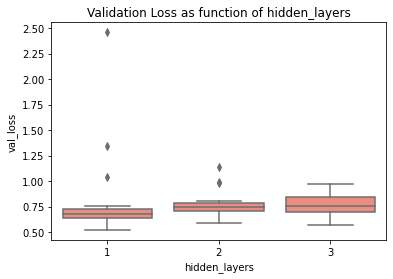

In [153]:
metric = 'hidden_layers'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of batch_size')

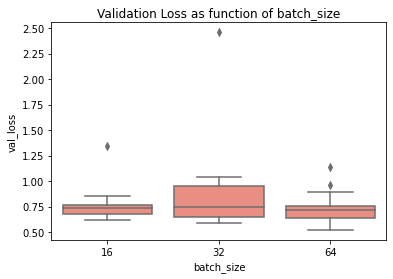

In [154]:
metric = 'batch_size'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of dropout')

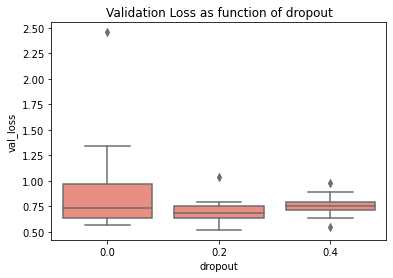

In [155]:
metric = 'dropout'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of batc_normalization')

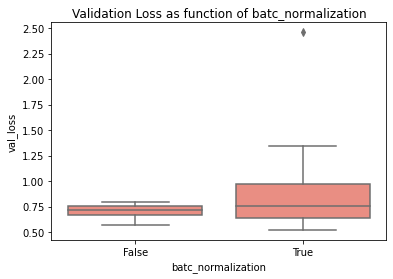

In [156]:
metric = 'batc_normalization'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

## Part 3.

In [163]:
p = {
    'first_neuron':[55],  #Done
     'hidden_neuron':[50], #Done

     'hidden_layers':[1], #Done  

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [64], #Done

    'lr':[0.001,0.0001,0.00001],
    
    'kernel_regularizer_l1':[0.0001],#[0,0.001,0.0001],
    'kernel_regularizer_l2':[0.0001],#[0,0.001,0.0001],
    'bias_regularizer':[0.0001],#[0,0.001,0.0001],
    'activity_regularizer':[0.0001],#[0,0.001,0.0001],

    #'dropout': [0,0.1,0.2,0.3,0.4],
    'dropout': [0],
    
  
    'kernel_initializer': ['orthogonal','identity','zeros','ones','uniform'],

    'activation_layer':['sigmoid','tanh','selu','elu','relu'],
 
    'batc_normalization':[False], #Done
 
}

In [164]:
t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy M - Weighted binary cross-entropy (nowe)')

Restoring model weights from the end of the best epoch: 3095.
Epoch 03145: early stopping




 15%|████████████                                                                      | 11/75 [03:27<47:43, 44.74s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_



 16%|████████████▋                                                                  | 12/75 [10:04<2:39:34, 151.97s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n



 17%|█████████████▋                                                                 | 13/75 [10:08<1:50:37, 107.06s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_



 19%|██████████████▉                                                                 | 14/75 [10:13<1:17:36, 76.33s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n



 20%|████████████████▍                                                                 | 15/75 [10:16<54:22, 54.37s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n



 21%|█████████████████▍                                                                | 16/75 [10:24<39:33, 40.24s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_



 23%|██████████████████▌                                                               | 17/75 [10:27<28:12, 29.19s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n



 24%|███████████████████▋                                                              | 18/75 [10:33<21:01, 22.13s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not



 25%|████████████████████▊                                                             | 19/75 [10:41<16:35, 17.78s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_no



 27%|█████████████████████▊                                                            | 20/75 [10:47<13:10, 14.37s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not



 28%|██████████████████████▉                                                           | 21/75 [10:55<11:03, 12.29s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_co



 29%|████████████████████████                                                          | 22/75 [10:58<08:31,  9.65s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_c



 31%|█████████████████████████▏                                                        | 23/75 [11:02<06:44,  7.79s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_co



 32%|██████████████████████████▏                                                       | 24/75 [11:05<05:31,  6.49s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_con



 33%|███████████████████████████▎                                                      | 25/75 [12:04<18:25, 22.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_co



 35%|████████████████████████████▍                                                     | 26/75 [13:37<35:38, 43.63s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_con



 36%|████████████████████████████▍                                                  | 27/75 [20:11<1:58:55, 148.66s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_



 37%|█████████████████████████████▍                                                 | 28/75 [20:15<1:22:22, 105.17s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not



 39%|███████████████████████████████▋                                                  | 29/75 [20:20<57:43, 75.29s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_



 40%|████████████████████████████████▊                                                 | 30/75 [20:24<40:18, 53.74s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n



 41%|█████████████████████████████████▉                                                | 31/75 [20:31<29:08, 39.73s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_



 43%|██████████████████████████████████▉                                               | 32/75 [20:34<20:40, 28.86s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n



 44%|████████████████████████████████████                                              | 33/75 [20:38<14:52, 21.26s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not



 45%|█████████████████████████████████████▏                                            | 34/75 [20:46<11:49, 17.30s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_no



 47%|██████████████████████████████████████▎                                           | 35/75 [20:52<09:20, 14.01s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not



 48%|███████████████████████████████████████▎                                          | 36/75 [21:00<07:54, 12.18s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_co



 49%|████████████████████████████████████████▍                                         | 37/75 [21:04<06:03,  9.57s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_c



 51%|█████████████████████████████████████████▌                                        | 38/75 [21:07<04:46,  7.75s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_co



 52%|██████████████████████████████████████████▋                                       | 39/75 [21:11<03:53,  6.48s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_con



 53%|███████████████████████████████████████████▋                                      | 40/75 [22:06<12:16, 21.04s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_co



 55%|████████████████████████████████████████████▊                                     | 41/75 [23:38<24:02, 42.43s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_con



 56%|████████████████████████████████████████████▏                                  | 42/75 [30:14<1:21:40, 148.50s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_



 57%|██████████████████████████████████████████████▍                                  | 43/75 [30:18<56:01, 105.05s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not



 59%|████████████████████████████████████████████████                                  | 44/75 [30:23<38:52, 75.26s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_



 60%|█████████████████████████████████████████████████▏                                | 45/75 [30:27<26:51, 53.72s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_no



 61%|██████████████████████████████████████████████████▎                               | 46/75 [30:32<18:54, 39.13s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n



 63%|███████████████████████████████████████████████████▍                              | 47/75 [30:38<13:38, 29.23s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_no



 64%|████████████████████████████████████████████████████▍                             | 48/75 [30:45<10:04, 22.40s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_



 65%|█████████████████████████████████████████████████████▌                            | 49/75 [30:52<07:46, 17.96s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not



 67%|██████████████████████████████████████████████████████▋                           | 50/75 [30:59<06:05, 14.61s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_



 68%|███████████████████████████████████████████████████████▊                          | 51/75 [31:06<04:58, 12.43s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_con



 69%|████████████████████████████████████████████████████████▊                         | 52/75 [31:10<03:44,  9.74s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_co



 71%|█████████████████████████████████████████████████████████▉                        | 53/75 [31:13<02:53,  7.86s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_con



 72%|███████████████████████████████████████████████████████████                       | 54/75 [31:17<02:17,  6.56s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_conv



 73%|████████████████████████████████████████████████████████████▏                     | 55/75 [32:15<07:22, 22.12s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_con



 75%|█████████████████████████████████████████████████████████████▏                    | 56/75 [33:49<13:46, 43.51s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_conv



 76%|█████████████████████████████████████████████████████████████▌                   | 57/75 [40:24<44:41, 148.96s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_c



 77%|██████████████████████████████████████████████████████████████▋                  | 58/75 [40:27<29:51, 105.39s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_



 79%|████████████████████████████████████████████████████████████████▌                 | 59/75 [40:33<20:05, 75.33s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_c



 80%|█████████████████████████████████████████████████████████████████▌                | 60/75 [40:36<13:26, 53.80s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n



 81%|██████████████████████████████████████████████████████████████████▋               | 61/75 [40:43<09:15, 39.66s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_



 83%|███████████████████████████████████████████████████████████████████▊              | 62/75 [40:46<06:14, 28.81s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n



 84%|████████████████████████████████████████████████████████████████████▉             | 63/75 [40:50<04:14, 21.22s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not



 85%|█████████████████████████████████████████████████████████████████████▉            | 64/75 [40:54<02:56, 16.05s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_no



 87%|███████████████████████████████████████████████████████████████████████           | 65/75 [41:01<02:12, 13.26s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not



 88%|████████████████████████████████████████████████████████████████████████▏         | 66/75 [41:08<01:44, 11.63s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_co



 89%|█████████████████████████████████████████████████████████████████████████▎        | 67/75 [41:12<01:13,  9.19s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_c



 91%|██████████████████████████████████████████████████████████████████████████▎       | 68/75 [41:15<00:52,  7.48s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_co



 92%|███████████████████████████████████████████████████████████████████████████▍      | 69/75 [41:19<00:37,  6.30s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_con



 93%|████████████████████████████████████████████████████████████████████████████▌     | 70/75 [42:18<01:50, 22.00s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_co



 95%|█████████████████████████████████████████████████████████████████████████████▋    | 71/75 [43:51<02:53, 43.34s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_con



 96%|█████████████████████████████████████████████████████████████████████████████▊   | 72/75 [50:24<07:25, 148.41s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_



 97%|██████████████████████████████████████████████████████████████████████████████▊  | 73/75 [50:28<03:30, 105.02s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not



 99%|████████████████████████████████████████████████████████████████████████████████▉ | 74/75 [50:33<01:15, 75.07s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_



100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [50:37<00:00, 40.50s/it]


In [174]:
df = pd.read_csv('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/M/Predykcja klasy M - Weighted binary cross-entropy (nowe)/050722004321.csv')

In [175]:
df 

,round_epochs,loss,fbeta_score,precision,recall,val_loss,val_fbeta_score,val_precision,val_recall,activation_layer,...,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
0,141,0.592331,[0.36585367],0.247934,0.697674,0.658958,[0.4],0.444444,0.363636,sigmoid,...,0,100000,55,1,50,orthogonal,0.0001,0.0001,sigmoid,0.00100
1,181,0.677652,[0.31716418],0.188889,0.988372,0.710377,[0.29850748],0.178571,0.909091,sigmoid,...,0,100000,55,1,50,orthogonal,0.0001,0.0001,sigmoid,0.00010
2,206,0.748390,[0.29038113],0.172043,0.930233,0.767352,[0.2898551],0.172414,0.909091,sigmoid,...,0,100000,55,1,50,orthogonal,0.0001,0.0001,sigmoid,0.00001
3,67,0.627819,[0.31439397],0.187783,0.965116,0.661901,[0.28571427],0.180723,0.681818,sigmoid,...,0,100000,55,1,50,identity,0.0001,0.0001,sigmoid,0.00100
4,137,0.672291,[0.28975263],0.170833,0.953488,0.670327,[0.3007519],0.180180,0.909091,sigmoid,...,0,100000,55,1,50,identity,0.0001,0.0001,sigmoid,0.00010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,3122,0.749368,[0.26153845],0.150709,0.988372,0.752426,[0.26993865],0.156028,1.000000,relu,...,0,100000,55,1,50,ones,0.0001,0.0001,sigmoid,0.00010
71,13355,0.896214,[0.],0.000000,0.000000,0.822566,[0.],0.000000,0.000000,relu,...,0,100000,55,1,50,ones,0.0001,0.0001,sigmoid,0.00001
72,60,0.611656,[0.31119546],0.185941,0.953488,0.694541,[0.2962963],0.176991,0.909091,relu,...,0,100000,55,1,50,uniform,0.0001,0.0001,sigmoid,0.00100
73,108,0.642046,[0.3016158],0.178344,0.976744,0.654796,[0.29197082],0.173913,0.909091,relu,...,0,100000,55,1,50,uniform,0.0001,0.0001,sigmoid,0.00010


In [176]:
df=df.sort_values('val_loss',ascending=False)

In [177]:
stare_wart=df['val_fbeta_score']
nowe_wart=[]
for x in stare_wart:
    wart=x.replace('[','')
    wart=wart.replace(']','')
    wart=float(wart)
    nowe_wart.append(wart)

In [178]:
df['val_fbeta_score']=nowe_wart

In [179]:
df

,round_epochs,loss,fbeta_score,precision,recall,val_loss,val_fbeta_score,val_precision,val_recall,activation_layer,...,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
11,13356,0.896150,[0.],0.000000,0.000000,0.822645,0.000000,0.000000,0.000000,sigmoid,...,0,100000,55,1,50,ones,0.0001,0.0001,sigmoid,0.00001
71,13355,0.896214,[0.],0.000000,0.000000,0.822566,0.000000,0.000000,0.000000,relu,...,0,100000,55,1,50,ones,0.0001,0.0001,sigmoid,0.00001
41,13352,0.895954,[0.],0.000000,0.000000,0.822309,0.000000,0.000000,0.000000,selu,...,0,100000,55,1,50,ones,0.0001,0.0001,sigmoid,0.00001
56,13374,0.892291,[0.],0.000000,0.000000,0.818881,0.000000,0.000000,0.000000,elu,...,0,100000,55,1,50,ones,0.0001,0.0001,sigmoid,0.00001
26,13407,0.886114,[0.],0.000000,0.000000,0.813588,0.000000,0.000000,0.000000,tanh,...,0,100000,55,1,50,ones,0.0001,0.0001,sigmoid,0.00001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,192,0.560562,[0.41447368],0.288991,0.732558,0.608270,0.350000,0.388889,0.318182,tanh,...,0,100000,55,1,50,identity,0.0001,0.0001,sigmoid,0.00100
30,173,0.569226,[0.3806452],0.263393,0.686047,0.586448,0.250000,0.400000,0.181818,selu,...,0,100000,55,1,50,orthogonal,0.0001,0.0001,sigmoid,0.00100
48,193,0.554448,[0.4164038],0.285714,0.767442,0.560349,0.368421,0.437500,0.318182,elu,...,0,100000,55,1,50,identity,0.0001,0.0001,sigmoid,0.00100
33,209,0.544065,[0.4043127],0.263158,0.872093,0.541987,0.388889,0.500000,0.318182,selu,...,0,100000,55,1,50,identity,0.0001,0.0001,sigmoid,0.00100


Text(0.5, 1.0, 'Validation Loss as function of kernel_initializer')

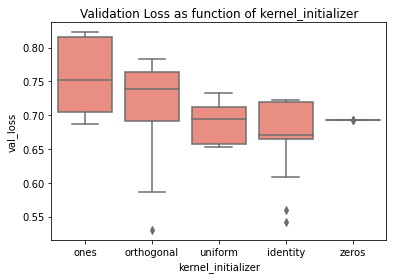

In [180]:
metric = 'kernel_initializer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of activation_layer')

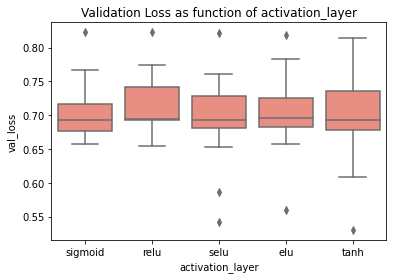

In [181]:
metric = 'activation_layer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of lr')

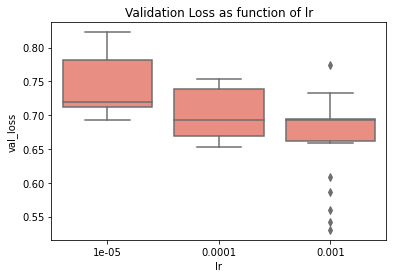

In [173]:
metric = 'lr'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

## Part 4

In [22]:

def numerai_model(x_train, y_train, x_val, y_val, params):
    
    print(params)

    model = Sequential()
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
               
                    kernel_initializer = params['kernel_initializer'],
                    kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    if params['batc_normalization']==True:
        model.add(BatchNormalization())
        
    if params['dropout']!=0:
        model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer'],
                        kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                    l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                       ))
        if params['batc_normalization']==True:
            model.add(BatchNormalization())
            
        if params['dropout']!=0:
            model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer'],
                   kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                               l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    
    model.compile(loss='binary_crossentropy',

                  optimizer=tf.keras.optimizers.Adam(learning_rate=params['lr']),
                  metrics=[tfa.metrics.FBetaScore(num_classes=1, beta=1.0, threshold=0.5),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),])
  
  
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0,
                        class_weight={0 : 0.58921162,
                                      1 : 3.30232558},
                        callbacks = [
                                     EarlyStopping(monitor='val_loss',
                                        min_delta=0.01,
                                        patience=50, mode='min',verbose=1,
                                                      restore_best_weights=True)
                                    ] #,ta.live(),
                        )

    return history, model

In [20]:
p = {
    'first_neuron':[55],  #Done
     'hidden_neuron':[50], #Done

     'hidden_layers':[1], #Done  

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [64], #Done

    'lr':[0.01,0.001,0.0001],
    
    'kernel_regularizer_l1':[0,0.001,0.0001],
    'kernel_regularizer_l2':[0,0.001,0.0001],
    'bias_regularizer':[0,0.001,0.0001],
    'activity_regularizer':[0,0.001,0.0001],

  #  'dropout': [0,0.1,0.2,0.3,0.4],
  'dropout': [0,0.1],

  
    'kernel_initializer': ['identity'],

    'activation_layer':['tanh'],
 
    'batc_normalization':[False], #Done
 
}

In [23]:
t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy M - Weighted binary cross-entropy (nowe)')

  0%|                                                                                          | 0/486 [00:00<?, ?it/s]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 33.
Epoch 83: early stopping


  0%|▏                                                                                 | 1/486 [00:06<55:48,  6.90s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 18.
Epoch 68: early stopping


  0%|▎                                                                                 | 2/486 [00:11<46:23,  5.75s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 109.
Epoch 159: early stopping


  1%|▌                                                                                 | 3/486 [00:19<54:43,  6.80s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 31.
Epoch 81: early stopping


  1%|▋                                                                                 | 4/486 [00:24<49:03,  6.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 143.
Epoch 193: early stopping


  1%|▊                                                                                 | 5/486 [00:34<58:24,  7.29s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 137.
Epoch 187: early stopping


  1%|▉                                                                               | 6/486 [00:43<1:04:10,  8.02s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 13.
Epoch 63: early stopping


  1%|█▏                                                                                | 7/486 [00:47<54:08,  6.78s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 143.
Epoch 193: early stopping


  2%|█▎                                                                              | 8/486 [00:58<1:03:51,  8.02s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 86.
Epoch 136: early stopping


  2%|█▍                                                                              | 9/486 [01:07<1:04:55,  8.17s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 20.
Epoch 70: early stopping


  2%|█▋                                                                               | 10/486 [01:12<58:27,  7.37s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 111.
Epoch 161: early stopping


  2%|█▊                                                                             | 11/486 [01:21<1:00:53,  7.69s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 42.
Epoch 92: early stopping


  2%|██                                                                               | 12/486 [01:26<55:50,  7.07s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 17.
Epoch 67: early stopping


  3%|██▏                                                                              | 13/486 [01:31<51:06,  6.48s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 129.
Epoch 179: early stopping


  3%|██▎                                                                              | 14/486 [01:41<58:00,  7.37s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 321.
Epoch 371: early stopping


  3%|██▍                                                                            | 15/486 [01:58<1:20:43, 10.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 14.
Epoch 64: early stopping


  3%|██▌                                                                            | 16/486 [02:02<1:06:52,  8.54s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 124.
Epoch 174: early stopping


  3%|██▊                                                                            | 17/486 [02:11<1:07:34,  8.64s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 58.
Epoch 108: early stopping


  4%|██▉                                                                            | 18/486 [02:18<1:01:50,  7.93s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 22.
Epoch 72: early stopping


  4%|███▏                                                                             | 19/486 [02:22<54:03,  6.95s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 23.
Epoch 73: early stopping


  4%|███▎                                                                             | 20/486 [02:27<48:45,  6.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 76.
Epoch 126: early stopping


  4%|███▌                                                                             | 21/486 [02:34<50:20,  6.50s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 50.
Epoch 100: early stopping


  5%|███▋                                                                             | 22/486 [02:40<49:38,  6.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 22.
Epoch 72: early stopping


  5%|███▊                                                                             | 23/486 [02:47<49:31,  6.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 144.
Epoch 194: early stopping


  5%|████                                                                             | 24/486 [02:57<59:27,  7.72s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 6.
Epoch 56: early stopping


  5%|████▏                                                                            | 25/486 [03:01<50:59,  6.64s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 12.
Epoch 62: early stopping


  5%|████▎                                                                            | 26/486 [03:06<45:52,  5.98s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 81.
Epoch 131: early stopping


  6%|████▌                                                                            | 27/486 [03:13<48:54,  6.39s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 21.
Epoch 71: early stopping


  6%|████▋                                                                            | 28/486 [03:18<45:18,  5.94s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 19.
Epoch 69: early stopping


  6%|████▊                                                                            | 29/486 [03:24<44:56,  5.90s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 98.
Epoch 148: early stopping


  6%|█████                                                                            | 30/486 [03:32<49:38,  6.53s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 29.
Epoch 79: early stopping


  6%|█████▏                                                                           | 31/486 [03:37<46:22,  6.12s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 21.
Epoch 71: early stopping


  7%|█████▎                                                                           | 32/486 [03:42<43:28,  5.75s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 154.
Epoch 204: early stopping


  7%|█████▌                                                                           | 33/486 [03:53<54:14,  7.18s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 8.
Epoch 58: early stopping


  7%|█████▋                                                                           | 34/486 [03:57<47:40,  6.33s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 32.
Epoch 82: early stopping


  7%|█████▊                                                                           | 35/486 [04:02<45:31,  6.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 98.
Epoch 148: early stopping


  7%|██████                                                                           | 36/486 [04:14<57:54,  7.72s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 41.
Epoch 91: early stopping


  8%|██████▏                                                                          | 37/486 [04:20<53:40,  7.17s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 108.
Epoch 158: early stopping


  8%|██████▎                                                                          | 38/486 [04:28<56:38,  7.59s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 39.
Epoch 89: early stopping


  8%|██████▌                                                                          | 39/486 [04:34<52:47,  7.09s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 20.
Epoch 70: early stopping


  8%|██████▋                                                                          | 40/486 [04:39<48:00,  6.46s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 138.
Epoch 188: early stopping


  8%|██████▊                                                                          | 41/486 [04:49<55:44,  7.52s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 279.
Epoch 329: early stopping


  9%|██████▊                                                                        | 42/486 [05:05<1:14:31, 10.07s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 38.
Epoch 88: early stopping


  9%|██████▉                                                                        | 43/486 [05:11<1:04:43,  8.77s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 121.
Epoch 171: early stopping


  9%|███████▏                                                                       | 44/486 [05:21<1:06:36,  9.04s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 30.
Epoch 80: early stopping


  9%|███████▌                                                                         | 45/486 [05:26<59:04,  8.04s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 13.
Epoch 63: early stopping


  9%|███████▋                                                                         | 46/486 [05:31<51:31,  7.03s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 43.
Epoch 93: early stopping


 10%|███████▊                                                                         | 47/486 [05:38<50:27,  6.90s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 80.
Epoch 130: early stopping


 10%|████████                                                                         | 48/486 [05:45<51:32,  7.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 18.
Epoch 68: early stopping


 10%|████████▏                                                                        | 49/486 [05:50<46:29,  6.38s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 225.
Epoch 275: early stopping


 10%|████████▏                                                                      | 50/486 [06:04<1:02:30,  8.60s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 140.
Epoch 190: early stopping


 10%|████████▎                                                                      | 51/486 [06:14<1:05:33,  9.04s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 16.
Epoch 66: early stopping


 11%|████████▋                                                                        | 52/486 [06:19<56:23,  7.80s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 11.
Epoch 61: early stopping


 11%|████████▊                                                                        | 53/486 [06:23<49:21,  6.84s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 85.
Epoch 135: early stopping


 11%|█████████                                                                        | 54/486 [06:31<51:14,  7.12s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 8.
Epoch 58: early stopping


 11%|█████████▏                                                                       | 55/486 [06:37<49:23,  6.88s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 18.
Epoch 68: early stopping


 12%|█████████▎                                                                       | 56/486 [06:42<44:04,  6.15s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 101.
Epoch 151: early stopping


 12%|█████████▌                                                                       | 57/486 [06:50<47:58,  6.71s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 23.
Epoch 73: early stopping


 12%|█████████▋                                                                       | 58/486 [06:55<44:17,  6.21s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 185.
Epoch 235: early stopping


 12%|█████████▊                                                                       | 59/486 [07:08<58:32,  8.23s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 120.
Epoch 170: early stopping


 12%|█████████▊                                                                     | 60/486 [07:19<1:05:09,  9.18s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 29.
Epoch 79: early stopping


 13%|██████████▏                                                                      | 61/486 [07:24<55:45,  7.87s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 16.
Epoch 66: early stopping


 13%|██████████▎                                                                      | 62/486 [07:29<49:21,  6.98s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 71.
Epoch 121: early stopping


 13%|██████████▌                                                                      | 63/486 [07:36<49:23,  7.01s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 30.
Epoch 80: early stopping


 13%|██████████▋                                                                      | 64/486 [07:42<48:04,  6.84s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 128.
Epoch 178: early stopping


 13%|██████████▊                                                                      | 65/486 [07:52<53:51,  7.68s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 74.
Epoch 124: early stopping


 14%|███████████                                                                      | 66/486 [07:58<51:17,  7.33s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 27.
Epoch 77: early stopping


 14%|███████████▏                                                                     | 67/486 [08:03<45:53,  6.57s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 143.
Epoch 193: early stopping


 14%|███████████▎                                                                     | 68/486 [08:13<51:16,  7.36s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 327.
Epoch 377: early stopping


 14%|███████████▏                                                                   | 69/486 [08:29<1:09:45, 10.04s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 63.
Epoch 113: early stopping


 14%|███████████▍                                                                   | 70/486 [08:35<1:02:21,  9.00s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 79.
Epoch 129: early stopping


 15%|███████████▊                                                                     | 71/486 [08:42<56:58,  8.24s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 72.
Epoch 122: early stopping


 15%|████████████                                                                     | 72/486 [08:48<52:14,  7.57s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 2.
Epoch 52: early stopping


 15%|████████████▏                                                                    | 73/486 [08:51<43:38,  6.34s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 18.
Epoch 68: early stopping


 15%|████████████▎                                                                    | 74/486 [08:56<39:19,  5.73s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 71.
Epoch 121: early stopping


 15%|████████████▌                                                                    | 75/486 [09:02<40:18,  5.88s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 13.
Epoch 63: early stopping


 16%|████████████▋                                                                    | 76/486 [09:06<37:05,  5.43s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 55.
Epoch 105: early stopping


 16%|████████████▊                                                                    | 77/486 [09:12<38:00,  5.58s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 123.
Epoch 173: early stopping


 16%|█████████████                                                                    | 78/486 [09:21<44:02,  6.48s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 3.
Epoch 53: early stopping


 16%|█████████████▏                                                                   | 79/486 [09:25<39:02,  5.75s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 11.
Epoch 61: early stopping


 16%|█████████████▎                                                                   | 80/486 [09:29<35:49,  5.29s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 91.
Epoch 141: early stopping


 17%|█████████████▌                                                                   | 81/486 [09:36<39:47,  5.89s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 11.
Epoch 61: early stopping


 17%|█████████████▋                                                                   | 82/486 [09:41<36:36,  5.44s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 20.
Epoch 70: early stopping


 17%|█████████████▊                                                                   | 83/486 [09:45<34:37,  5.15s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 126.
Epoch 176: early stopping


 17%|██████████████                                                                   | 84/486 [09:54<41:58,  6.26s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 25.
Epoch 75: early stopping


 17%|██████████████▏                                                                  | 85/486 [09:59<39:10,  5.86s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 55.
Epoch 105: early stopping


 18%|██████████████▎                                                                  | 86/486 [10:05<39:40,  5.95s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 149.
Epoch 199: early stopping


 18%|██████████████▌                                                                  | 87/486 [10:15<47:31,  7.15s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 31.
Epoch 81: early stopping


 18%|██████████████▋                                                                  | 88/486 [10:20<43:25,  6.55s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 31.
Epoch 81: early stopping


 18%|██████████████▊                                                                  | 89/486 [10:25<40:17,  6.09s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 99.
Epoch 149: early stopping


 19%|███████████████                                                                  | 90/486 [10:33<43:30,  6.59s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 29.
Epoch 79: early stopping


 19%|███████████████▏                                                                 | 91/486 [10:38<40:11,  6.10s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 87.
Epoch 137: early stopping


 19%|███████████████▎                                                                 | 92/486 [10:45<42:40,  6.50s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 54.
Epoch 104: early stopping


 19%|███████████████▌                                                                 | 93/486 [10:51<41:26,  6.33s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 21.
Epoch 71: early stopping


 19%|███████████████▋                                                                 | 94/486 [10:56<38:24,  5.88s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 147.
Epoch 197: early stopping


 20%|███████████████▊                                                                 | 95/486 [11:06<46:10,  7.09s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 268.
Epoch 318: early stopping


 20%|███████████████▌                                                               | 96/486 [11:21<1:00:32,  9.32s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 22.
Epoch 72: early stopping


 20%|████████████████▏                                                                | 97/486 [11:25<50:51,  7.84s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 107.
Epoch 157: early stopping


 20%|████████████████▎                                                                | 98/486 [11:33<50:33,  7.82s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 75.
Epoch 125: early stopping


 20%|████████████████▌                                                                | 99/486 [11:39<48:05,  7.46s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


 21%|████████████████▍                                                               | 100/486 [11:43<40:24,  6.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 22.
Epoch 72: early stopping


 21%|████████████████▋                                                               | 101/486 [11:47<36:44,  5.73s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 84.
Epoch 134: early stopping


 21%|████████████████▊                                                               | 102/486 [11:55<39:51,  6.23s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 19.
Epoch 69: early stopping


 21%|████████████████▉                                                               | 103/486 [12:00<38:01,  5.96s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 100.
Epoch 150: early stopping


 21%|█████████████████                                                               | 104/486 [12:08<42:40,  6.70s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 170.
Epoch 220: early stopping


 22%|█████████████████▎                                                              | 105/486 [12:20<52:23,  8.25s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 8.
Epoch 58: early stopping


 22%|█████████████████▍                                                              | 106/486 [12:25<46:06,  7.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 21.
Epoch 71: early stopping


 22%|█████████████████▌                                                              | 107/486 [12:31<42:48,  6.78s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 101.
Epoch 151: early stopping


 22%|█████████████████▊                                                              | 108/486 [12:40<46:04,  7.31s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 5.
Epoch 55: early stopping


 22%|█████████████████▉                                                              | 109/486 [12:46<44:19,  7.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 121.
Epoch 171: early stopping


 23%|██████████████████                                                              | 110/486 [12:55<47:34,  7.59s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 78.
Epoch 128: early stopping


 23%|██████████████████▎                                                             | 111/486 [13:02<45:53,  7.34s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 76.
Epoch 126: early stopping


 23%|██████████████████▍                                                             | 112/486 [13:08<44:11,  7.09s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 140.
Epoch 190: early stopping


 23%|██████████████████▌                                                             | 113/486 [13:20<52:23,  8.43s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 99.
Epoch 149: early stopping


 23%|██████████████████▊                                                             | 114/486 [13:28<51:23,  8.29s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 2.
Epoch 52: early stopping


 24%|██████████████████▉                                                             | 115/486 [13:32<44:44,  7.24s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 114.
Epoch 164: early stopping


 24%|███████████████████                                                             | 116/486 [13:42<48:39,  7.89s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 81.
Epoch 131: early stopping


 24%|███████████████████▎                                                            | 117/486 [13:50<48:57,  7.96s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 20.
Epoch 70: early stopping


 24%|███████████████████▍                                                            | 118/486 [13:55<42:39,  6.95s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 101.
Epoch 151: early stopping


 24%|███████████████████▌                                                            | 119/486 [14:02<43:45,  7.15s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 91.
Epoch 141: early stopping


 25%|███████████████████▊                                                            | 120/486 [14:09<43:14,  7.09s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 14.
Epoch 64: early stopping


 25%|███████████████████▉                                                            | 121/486 [14:13<37:32,  6.17s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 149.
Epoch 199: early stopping


 25%|████████████████████                                                            | 122/486 [14:22<43:06,  7.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 309.
Epoch 359: early stopping


 25%|███████████████████▋                                                          | 123/486 [14:44<1:09:28, 11.48s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 59.
Epoch 109: early stopping


 26%|████████████████████▍                                                           | 124/486 [14:50<59:06,  9.80s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 131.
Epoch 181: early stopping


 26%|████████████████████▌                                                           | 125/486 [14:59<56:57,  9.47s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 188.
Epoch 238: early stopping


 26%|████████████████████▋                                                           | 126/486 [15:10<59:27,  9.91s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 4.
Epoch 54: early stopping


 26%|████████████████████▉                                                           | 127/486 [15:13<48:16,  8.07s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 20.
Epoch 70: early stopping


 26%|█████████████████████                                                           | 128/486 [15:18<41:28,  6.95s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 88.
Epoch 138: early stopping


 27%|█████████████████████▏                                                          | 129/486 [15:29<49:40,  8.35s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 6.
Epoch 56: early stopping


 27%|█████████████████████▍                                                          | 130/486 [15:33<41:50,  7.05s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 173.
Epoch 223: early stopping


 27%|█████████████████████▌                                                          | 131/486 [15:43<47:02,  7.95s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 175.
Epoch 225: early stopping


 27%|█████████████████████▋                                                          | 132/486 [15:53<50:17,  8.52s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 6.
Epoch 56: early stopping


 27%|█████████████████████▉                                                          | 133/486 [16:00<46:22,  7.88s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 11.
Epoch 61: early stopping


 28%|██████████████████████                                                          | 134/486 [16:04<39:44,  6.77s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 84.
Epoch 134: early stopping


 28%|██████████████████████▏                                                         | 135/486 [16:11<40:09,  6.87s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 17.
Epoch 67: early stopping


 28%|██████████████████████▍                                                         | 136/486 [16:15<35:40,  6.12s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 23.
Epoch 73: early stopping


 28%|██████████████████████▌                                                         | 137/486 [16:20<33:13,  5.71s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 106.
Epoch 156: early stopping


 28%|██████████████████████▋                                                         | 138/486 [16:28<37:12,  6.41s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 5.
Epoch 55: early stopping


 29%|██████████████████████▉                                                         | 139/486 [16:32<33:09,  5.73s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 184.
Epoch 234: early stopping


 29%|███████████████████████                                                         | 140/486 [16:44<42:48,  7.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 164.
Epoch 214: early stopping


 29%|███████████████████████▏                                                        | 141/486 [16:54<47:58,  8.34s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 2.
Epoch 52: early stopping


 29%|███████████████████████▎                                                        | 142/486 [16:59<41:38,  7.26s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 36.
Epoch 86: early stopping


 29%|███████████████████████▌                                                        | 143/486 [17:05<39:36,  6.93s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 141.
Epoch 191: early stopping


 30%|███████████████████████▋                                                        | 144/486 [17:15<44:18,  7.77s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 41.
Epoch 91: early stopping


 30%|███████████████████████▊                                                        | 145/486 [17:22<42:53,  7.55s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 114.
Epoch 164: early stopping


 30%|████████████████████████                                                        | 146/486 [17:34<50:36,  8.93s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 73.
Epoch 123: early stopping


 30%|████████████████████████▏                                                       | 147/486 [17:41<47:12,  8.35s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 17.
Epoch 67: early stopping


 30%|████████████████████████▎                                                       | 148/486 [17:48<45:04,  8.00s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 159.
Epoch 209: early stopping


 31%|████████████████████████▌                                                       | 149/486 [17:57<47:01,  8.37s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 255.
Epoch 305: early stopping


 31%|████████████████████████▋                                                       | 150/486 [18:13<59:52, 10.69s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 22.
Epoch 72: early stopping


 31%|████████████████████████▊                                                       | 151/486 [18:18<49:00,  8.78s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 125.
Epoch 175: early stopping


 31%|█████████████████████████                                                       | 152/486 [18:28<52:04,  9.36s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 55.
Epoch 105: early stopping


 31%|█████████████████████████▏                                                      | 153/486 [18:35<47:06,  8.49s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 8.
Epoch 58: early stopping


 32%|█████████████████████████▎                                                      | 154/486 [18:41<43:40,  7.89s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 17.
Epoch 67: early stopping


 32%|█████████████████████████▌                                                      | 155/486 [18:48<40:59,  7.43s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 99.
Epoch 149: early stopping


 32%|█████████████████████████▋                                                      | 156/486 [18:56<41:57,  7.63s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 15.
Epoch 65: early stopping


 32%|█████████████████████████▊                                                      | 157/486 [19:01<37:12,  6.79s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 152.
Epoch 202: early stopping


 33%|██████████████████████████                                                      | 158/486 [19:12<45:15,  8.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 115.
Epoch 165: early stopping


 33%|██████████████████████████▏                                                     | 159/486 [19:24<50:54,  9.34s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


 33%|██████████████████████████▎                                                     | 160/486 [19:31<46:01,  8.47s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 28.
Epoch 78: early stopping


 33%|██████████████████████████▌                                                     | 161/486 [19:36<40:15,  7.43s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 78.
Epoch 128: early stopping


 33%|██████████████████████████▋                                                     | 162/486 [19:48<47:18,  8.76s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 5.
Epoch 55: early stopping


 34%|██████████████████████████▊                                                     | 163/486 [19:52<39:29,  7.34s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 88.
Epoch 138: early stopping


 34%|██████████████████████████▉                                                     | 164/486 [20:03<46:13,  8.61s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 180.
Epoch 230: early stopping


 34%|███████████████████████████▏                                                    | 165/486 [20:14<49:24,  9.24s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 13.
Epoch 63: early stopping


 34%|███████████████████████████▎                                                    | 166/486 [20:20<44:46,  8.39s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 157.
Epoch 207: early stopping


 34%|███████████████████████████▍                                                    | 167/486 [20:31<47:37,  8.96s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 162.
Epoch 212: early stopping


 35%|███████████████████████████▋                                                    | 168/486 [20:41<49:28,  9.33s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 3.
Epoch 53: early stopping


 35%|███████████████████████████▊                                                    | 169/486 [20:47<44:57,  8.51s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 92.
Epoch 142: early stopping


 35%|███████████████████████████▉                                                    | 170/486 [20:55<43:08,  8.19s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 163.
Epoch 213: early stopping


 35%|████████████████████████████▏                                                   | 171/486 [21:06<47:11,  8.99s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 47.
Epoch 97: early stopping


 35%|████████████████████████████▎                                                   | 172/486 [21:12<42:47,  8.18s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 132.
Epoch 182: early stopping


 36%|████████████████████████████▍                                                   | 173/486 [21:21<43:56,  8.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 265.
Epoch 315: early stopping


 36%|████████████████████████████▋                                                   | 174/486 [21:34<50:44,  9.76s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 21.
Epoch 71: early stopping


 36%|████████████████████████████▊                                                   | 175/486 [21:38<41:34,  8.02s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 206.
Epoch 256: early stopping


 36%|████████████████████████████▉                                                   | 176/486 [21:49<46:47,  9.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 789.
Epoch 839: early stopping


 36%|████████████████████████████▍                                                 | 177/486 [22:20<1:20:42, 15.67s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 19.
Epoch 69: early stopping


 37%|████████████████████████████▌                                                 | 178/486 [22:24<1:02:22, 12.15s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 101.
Epoch 151: early stopping


 37%|█████████████████████████████▍                                                  | 179/486 [22:31<53:55, 10.54s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 250.
Epoch 300: early stopping


 37%|█████████████████████████████▋                                                  | 180/486 [22:43<56:03, 10.99s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 33.
Epoch 83: early stopping


 37%|█████████████████████████████▊                                                  | 181/486 [22:47<45:43,  9.00s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 137.
Epoch 187: early stopping


 37%|█████████████████████████████▉                                                  | 182/486 [22:55<43:59,  8.68s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 162.
Epoch 212: early stopping


 38%|██████████████████████████████                                                  | 183/486 [23:04<44:25,  8.80s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 41.
Epoch 91: early stopping


 38%|██████████████████████████████▎                                                 | 184/486 [23:09<37:53,  7.53s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 203.
Epoch 253: early stopping


 38%|██████████████████████████████▍                                                 | 185/486 [23:19<41:42,  8.31s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 218.
Epoch 268: early stopping


 38%|██████████████████████████████▌                                                 | 186/486 [23:30<45:00,  9.00s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 2.
Epoch 52: early stopping


 38%|██████████████████████████████▊                                                 | 187/486 [23:33<36:15,  7.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 118.
Epoch 168: early stopping


 39%|██████████████████████████████▉                                                 | 188/486 [23:40<36:08,  7.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 165.
Epoch 215: early stopping


 39%|███████████████████████████████                                                 | 189/486 [23:49<38:24,  7.76s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 27.
Epoch 77: early stopping


 39%|███████████████████████████████▎                                                | 190/486 [23:53<32:51,  6.66s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 112.
Epoch 162: early stopping


 39%|███████████████████████████████▍                                                | 191/486 [24:00<33:29,  6.81s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 165.
Epoch 215: early stopping


 40%|███████████████████████████████▌                                                | 192/486 [24:10<36:39,  7.48s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 158.
Epoch 208: early stopping


 40%|███████████████████████████████▊                                                | 193/486 [24:18<38:38,  7.91s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 122.
Epoch 172: early stopping


 40%|███████████████████████████████▉                                                | 194/486 [24:26<37:58,  7.80s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 183.
Epoch 233: early stopping


 40%|████████████████████████████████                                                | 195/486 [24:36<40:32,  8.36s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 46.
Epoch 96: early stopping


 40%|████████████████████████████████▎                                               | 196/486 [24:40<35:18,  7.31s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 115.
Epoch 165: early stopping


 41%|████████████████████████████████▍                                               | 197/486 [24:48<35:12,  7.31s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 174.
Epoch 224: early stopping


 41%|████████████████████████████████▌                                               | 198/486 [24:57<38:12,  7.96s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 23.
Epoch 73: early stopping


 41%|████████████████████████████████▊                                               | 199/486 [25:01<32:29,  6.79s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 103.
Epoch 153: early stopping


 41%|████████████████████████████████▉                                               | 200/486 [25:08<32:29,  6.82s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 193.
Epoch 243: early stopping


 41%|█████████████████████████████████                                               | 201/486 [25:18<37:05,  7.81s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 45.
Epoch 95: early stopping


 42%|█████████████████████████████████▎                                              | 202/486 [25:23<32:49,  6.93s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 174.
Epoch 224: early stopping


 42%|█████████████████████████████████▍                                              | 203/486 [25:33<36:32,  7.75s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 595.
Epoch 645: early stopping


 42%|████████████████████████████████▋                                             | 204/486 [25:58<1:00:23, 12.85s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 103.
Epoch 153: early stopping


 42%|█████████████████████████████████▋                                              | 205/486 [26:05<52:05, 11.12s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 111.
Epoch 161: early stopping


 42%|█████████████████████████████████▉                                              | 206/486 [26:12<46:33,  9.98s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 183.
Epoch 233: early stopping


 43%|██████████████████████████████████                                              | 207/486 [26:22<46:18,  9.96s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 5.
Epoch 55: early stopping


 43%|██████████████████████████████████▏                                             | 208/486 [26:25<37:04,  8.00s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 194.
Epoch 244: early stopping


 43%|██████████████████████████████████▍                                             | 209/486 [26:36<39:54,  8.65s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 177.
Epoch 227: early stopping


 43%|██████████████████████████████████▌                                             | 210/486 [26:45<40:55,  8.90s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 68.
Epoch 118: early stopping


 43%|██████████████████████████████████▋                                             | 211/486 [26:51<36:25,  7.95s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 229.
Epoch 279: early stopping


 44%|██████████████████████████████████▉                                             | 212/486 [27:02<41:17,  9.04s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 179.
Epoch 229: early stopping


 44%|███████████████████████████████████                                             | 213/486 [27:14<44:14,  9.72s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 4.
Epoch 54: early stopping


 44%|███████████████████████████████████▏                                            | 214/486 [27:17<35:34,  7.85s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 206.
Epoch 256: early stopping


 44%|███████████████████████████████████▍                                            | 215/486 [27:28<40:09,  8.89s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 140.
Epoch 190: early stopping


 44%|███████████████████████████████████▌                                            | 216/486 [27:37<39:18,  8.73s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 18.
Epoch 68: early stopping


 45%|███████████████████████████████████▋                                            | 217/486 [27:40<32:18,  7.21s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 99.
Epoch 149: early stopping


 45%|███████████████████████████████████▉                                            | 218/486 [27:47<31:04,  6.96s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 160.
Epoch 210: early stopping


 45%|████████████████████████████████████                                            | 219/486 [27:55<32:53,  7.39s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 47.
Epoch 97: early stopping


 45%|████████████████████████████████████▏                                           | 220/486 [28:00<29:09,  6.58s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 151.
Epoch 201: early stopping


 45%|████████████████████████████████████▍                                           | 221/486 [28:08<31:12,  7.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 158.
Epoch 208: early stopping


 46%|████████████████████████████████████▌                                           | 222/486 [28:17<32:56,  7.49s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 25.
Epoch 75: early stopping


 46%|████████████████████████████████████▋                                           | 223/486 [28:21<28:08,  6.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 58.
Epoch 108: early stopping


 46%|████████████████████████████████████▊                                           | 224/486 [28:26<26:15,  6.01s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 142.
Epoch 192: early stopping


 46%|█████████████████████████████████████                                           | 225/486 [28:33<28:38,  6.58s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 63.
Epoch 113: early stopping


 47%|█████████████████████████████████████▏                                          | 226/486 [28:39<27:03,  6.24s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 170.
Epoch 220: early stopping


 47%|█████████████████████████████████████▎                                          | 227/486 [28:48<30:27,  7.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 216.
Epoch 266: early stopping


 47%|█████████████████████████████████████▌                                          | 228/486 [29:10<49:11, 11.44s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 21.
Epoch 71: early stopping


 47%|█████████████████████████████████████▋                                          | 229/486 [29:14<39:26,  9.21s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 147.
Epoch 197: early stopping


 47%|█████████████████████████████████████▊                                          | 230/486 [29:22<38:15,  8.97s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 788.
Epoch 838: early stopping


 48%|█████████████████████████████████████                                         | 231/486 [29:53<1:05:55, 15.51s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 32.
Epoch 82: early stopping


 48%|██████████████████████████████████████▏                                         | 232/486 [29:57<51:33, 12.18s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 120.
Epoch 170: early stopping


 48%|██████████████████████████████████████▎                                         | 233/486 [30:05<45:33, 10.80s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 242.
Epoch 292: early stopping


 48%|██████████████████████████████████████▌                                         | 234/486 [30:17<46:35, 11.09s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 15.
Epoch 65: early stopping


 48%|██████████████████████████████████████▋                                         | 235/486 [30:20<37:09,  8.88s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 150.
Epoch 200: early stopping


 49%|██████████████████████████████████████▊                                         | 236/486 [30:32<39:59,  9.60s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 160.
Epoch 210: early stopping


 49%|███████████████████████████████████████                                         | 237/486 [30:40<38:57,  9.39s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 41.
Epoch 91: early stopping


 49%|███████████████████████████████████████▏                                        | 238/486 [30:45<32:57,  7.98s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 121.
Epoch 171: early stopping


 49%|███████████████████████████████████████▎                                        | 239/486 [30:53<32:20,  7.86s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 216.
Epoch 266: early stopping


 49%|███████████████████████████████████████▌                                        | 240/486 [31:03<35:51,  8.75s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 33.
Epoch 83: early stopping


 50%|███████████████████████████████████████▋                                        | 241/486 [31:08<30:24,  7.45s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 151.
Epoch 201: early stopping


 50%|███████████████████████████████████████▊                                        | 242/486 [31:16<31:40,  7.79s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 156.
Epoch 206: early stopping


 50%|████████████████████████████████████████                                        | 243/486 [31:25<32:37,  8.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 3.
Epoch 53: early stopping


 50%|████████████████████████████████████████▏                                       | 244/486 [31:29<26:48,  6.64s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 73.
Epoch 123: early stopping


 50%|████████████████████████████████████████▎                                       | 245/486 [31:34<25:48,  6.43s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 179.
Epoch 229: early stopping


 51%|████████████████████████████████████████▍                                       | 246/486 [31:44<29:45,  7.44s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 38.
Epoch 88: early stopping


 51%|████████████████████████████████████████▋                                       | 247/486 [31:49<26:23,  6.63s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 129.
Epoch 179: early stopping


 51%|████████████████████████████████████████▊                                       | 248/486 [31:57<28:01,  7.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 206.
Epoch 256: early stopping


 51%|████████████████████████████████████████▉                                       | 249/486 [32:08<32:29,  8.22s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 2.
Epoch 52: early stopping


 51%|█████████████████████████████████████████▏                                      | 250/486 [32:11<26:41,  6.79s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 75.
Epoch 125: early stopping


 52%|█████████████████████████████████████████▎                                      | 251/486 [32:18<25:51,  6.60s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 151.
Epoch 201: early stopping


 52%|█████████████████████████████████████████▍                                      | 252/486 [32:27<29:04,  7.46s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 35.
Epoch 85: early stopping


 52%|█████████████████████████████████████████▋                                      | 253/486 [32:32<25:50,  6.65s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 146.
Epoch 196: early stopping


 52%|█████████████████████████████████████████▊                                      | 254/486 [32:41<28:13,  7.30s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 198.
Epoch 248: early stopping


 52%|█████████████████████████████████████████▉                                      | 255/486 [32:51<31:55,  8.29s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 31.
Epoch 81: early stopping


 53%|██████████████████████████████████████████▏                                     | 256/486 [32:56<27:31,  7.18s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 124.
Epoch 174: early stopping


 53%|██████████████████████████████████████████▎                                     | 257/486 [33:04<28:22,  7.44s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 651.
Epoch 701: early stopping


 53%|██████████████████████████████████████████▍                                     | 258/486 [33:32<51:52, 13.65s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 46.
Epoch 96: early stopping


 53%|██████████████████████████████████████████▋                                     | 259/486 [33:37<42:01, 11.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 180.
Epoch 230: early stopping


 53%|██████████████████████████████████████████▊                                     | 260/486 [33:47<40:48, 10.83s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 175.
Epoch 225: early stopping


 54%|██████████████████████████████████████████▉                                     | 261/486 [33:57<39:43, 10.59s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 24.
Epoch 74: early stopping


 54%|███████████████████████████████████████████▏                                    | 262/486 [34:02<32:31,  8.71s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 161.
Epoch 211: early stopping


 54%|███████████████████████████████████████████▎                                    | 263/486 [34:11<33:08,  8.92s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 151.
Epoch 201: early stopping


 54%|███████████████████████████████████████████▍                                    | 264/486 [34:22<35:40,  9.64s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 54.
Epoch 104: early stopping


 55%|███████████████████████████████████████████▌                                    | 265/486 [34:28<30:56,  8.40s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 225.
Epoch 275: early stopping


 55%|███████████████████████████████████████████▊                                    | 266/486 [34:40<34:36,  9.44s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 239.
Epoch 289: early stopping


 55%|███████████████████████████████████████████▉                                    | 267/486 [34:52<37:41, 10.33s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 20.
Epoch 70: early stopping


 55%|████████████████████████████████████████████                                    | 268/486 [34:56<30:55,  8.51s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 155.
Epoch 205: early stopping


 55%|████████████████████████████████████████████▎                                   | 269/486 [35:06<31:34,  8.73s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 184.
Epoch 234: early stopping


 56%|████████████████████████████████████████████▍                                   | 270/486 [35:16<33:12,  9.22s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 67.
Epoch 117: early stopping


 56%|████████████████████████████████████████████▌                                   | 271/486 [35:22<29:04,  8.12s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 74.
Epoch 124: early stopping


 56%|████████████████████████████████████████████▊                                   | 272/486 [35:27<26:23,  7.40s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 146.
Epoch 196: early stopping


 56%|████████████████████████████████████████████▉                                   | 273/486 [35:36<27:09,  7.65s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 35.
Epoch 85: early stopping


 56%|█████████████████████████████████████████████                                   | 274/486 [35:40<23:35,  6.68s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 129.
Epoch 179: early stopping


 57%|█████████████████████████████████████████████▎                                  | 275/486 [35:48<24:35,  6.99s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 160.
Epoch 210: early stopping


 57%|█████████████████████████████████████████████▍                                  | 276/486 [35:56<26:20,  7.52s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 62.
Epoch 112: early stopping


 57%|█████████████████████████████████████████████▌                                  | 277/486 [36:02<24:01,  6.90s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 82.
Epoch 132: early stopping


 57%|█████████████████████████████████████████████▊                                  | 278/486 [36:08<23:01,  6.64s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 170.
Epoch 220: early stopping


 57%|█████████████████████████████████████████████▉                                  | 279/486 [36:17<25:34,  7.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 48.
Epoch 98: early stopping


 58%|██████████████████████████████████████████████                                  | 280/486 [36:24<24:19,  7.08s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 144.
Epoch 194: early stopping


 58%|██████████████████████████████████████████████▎                                 | 281/486 [36:32<25:24,  7.44s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 225.
Epoch 275: early stopping


 58%|██████████████████████████████████████████████▍                                 | 282/486 [36:43<29:04,  8.55s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 38.
Epoch 88: early stopping


 58%|██████████████████████████████████████████████▌                                 | 283/486 [36:48<24:57,  7.38s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 177.
Epoch 227: early stopping


 58%|██████████████████████████████████████████████▋                                 | 284/486 [36:57<27:02,  8.03s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 779.
Epoch 829: early stopping


 59%|██████████████████████████████████████████████▉                                 | 285/486 [37:28<49:44, 14.85s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 91.
Epoch 141: early stopping


 59%|███████████████████████████████████████████████                                 | 286/486 [37:34<41:08, 12.34s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 135.
Epoch 185: early stopping


 59%|███████████████████████████████████████████████▏                                | 287/486 [37:42<36:39, 11.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 263.
Epoch 313: early stopping


 59%|███████████████████████████████████████████████▍                                | 288/486 [37:55<38:00, 11.52s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 9.
Epoch 59: early stopping


 59%|███████████████████████████████████████████████▌                                | 289/486 [37:59<29:57,  9.12s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 146.
Epoch 196: early stopping


 60%|███████████████████████████████████████████████▋                                | 290/486 [38:10<32:08,  9.84s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 173.
Epoch 223: early stopping


 60%|███████████████████████████████████████████████▉                                | 291/486 [38:20<31:53,  9.81s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 53.
Epoch 103: early stopping


 60%|████████████████████████████████████████████████                                | 292/486 [38:25<27:14,  8.43s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 169.
Epoch 219: early stopping


 60%|████████████████████████████████████████████████▏                               | 293/486 [38:34<27:57,  8.69s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 225.
Epoch 275: early stopping


 60%|████████████████████████████████████████████████▍                               | 294/486 [38:46<30:32,  9.54s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 36.
Epoch 86: early stopping


 61%|████████████████████████████████████████████████▌                               | 295/486 [38:50<25:37,  8.05s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 126.
Epoch 176: early stopping


 61%|████████████████████████████████████████████████▋                               | 296/486 [38:58<25:12,  7.96s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 187.
Epoch 237: early stopping


 61%|████████████████████████████████████████████████▉                               | 297/486 [39:08<26:55,  8.55s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 84.
Epoch 134: early stopping


 61%|█████████████████████████████████████████████████                               | 298/486 [39:20<29:32,  9.43s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 107.
Epoch 157: early stopping


 62%|█████████████████████████████████████████████████▏                              | 299/486 [39:27<27:30,  8.83s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 148.
Epoch 198: early stopping


 62%|█████████████████████████████████████████████████▍                              | 300/486 [39:36<27:15,  8.79s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 25.
Epoch 75: early stopping


 62%|█████████████████████████████████████████████████▌                              | 301/486 [39:40<22:58,  7.45s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 153.
Epoch 203: early stopping


 62%|█████████████████████████████████████████████████▋                              | 302/486 [39:49<24:14,  7.91s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 524.
Epoch 574: early stopping


 62%|█████████████████████████████████████████████████▉                              | 303/486 [40:12<37:29, 12.29s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 4.
Epoch 54: early stopping


 63%|██████████████████████████████████████████████████                              | 304/486 [40:15<29:18,  9.66s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 105.
Epoch 155: early stopping


 63%|██████████████████████████████████████████████████▏                             | 305/486 [40:22<26:55,  8.93s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 159.
Epoch 209: early stopping


 63%|██████████████████████████████████████████████████▎                             | 306/486 [40:31<26:58,  8.99s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 32.
Epoch 82: early stopping


 63%|██████████████████████████████████████████████████▌                             | 307/486 [40:36<22:51,  7.66s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 104.
Epoch 154: early stopping


 63%|██████████████████████████████████████████████████▋                             | 308/486 [40:43<22:18,  7.52s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 165.
Epoch 215: early stopping


 64%|██████████████████████████████████████████████████▊                             | 309/486 [40:53<23:53,  8.10s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 64.
Epoch 114: early stopping


 64%|███████████████████████████████████████████████████                             | 310/486 [40:58<21:42,  7.40s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 167.
Epoch 217: early stopping


 64%|███████████████████████████████████████████████████▏                            | 311/486 [41:08<23:34,  8.08s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 718.
Epoch 768: early stopping


 64%|███████████████████████████████████████████████████▎                            | 312/486 [41:38<42:31, 14.66s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 61.
Epoch 111: early stopping


 64%|███████████████████████████████████████████████████▌                            | 313/486 [41:44<34:30, 11.97s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 109.
Epoch 159: early stopping


 65%|███████████████████████████████████████████████████▋                            | 314/486 [41:51<30:30, 10.64s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 178.
Epoch 228: early stopping


 65%|███████████████████████████████████████████████████▊                            | 315/486 [42:01<29:52, 10.48s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 3.
Epoch 53: early stopping


 65%|████████████████████████████████████████████████████                            | 316/486 [42:05<23:50,  8.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 156.
Epoch 206: early stopping


 65%|████████████████████████████████████████████████████▏                           | 317/486 [42:14<24:17,  8.63s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 185.
Epoch 235: early stopping


 65%|████████████████████████████████████████████████████▎                           | 318/486 [42:24<25:32,  9.12s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 80.
Epoch 130: early stopping


 66%|████████████████████████████████████████████████████▌                           | 319/486 [42:36<27:25,  9.86s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 144.
Epoch 194: early stopping


 66%|████████████████████████████████████████████████████▋                           | 320/486 [42:45<26:27,  9.56s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 277.
Epoch 327: early stopping


 66%|████████████████████████████████████████████████████▊                           | 321/486 [43:07<36:22, 13.23s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 48.
Epoch 98: early stopping


 66%|█████████████████████████████████████████████████████                           | 322/486 [43:12<29:36, 10.83s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 138.
Epoch 188: early stopping


 66%|█████████████████████████████████████████████████████▏                          | 323/486 [43:21<27:38, 10.18s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 145.
Epoch 195: early stopping


 67%|█████████████████████████████████████████████████████▎                          | 324/486 [43:29<26:26,  9.79s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 4.
Epoch 54: early stopping


 67%|█████████████████████████████████████████████████████▍                          | 325/486 [43:33<21:00,  7.83s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 82.
Epoch 132: early stopping


 67%|█████████████████████████████████████████████████████▋                          | 326/486 [43:39<19:36,  7.36s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 140.
Epoch 190: early stopping


 67%|█████████████████████████████████████████████████████▊                          | 327/486 [43:47<19:54,  7.51s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 4.
Epoch 54: early stopping


 67%|█████████████████████████████████████████████████████▉                          | 328/486 [43:50<16:32,  6.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 124.
Epoch 174: early stopping


 68%|██████████████████████████████████████████████████████▏                         | 329/486 [43:58<17:28,  6.68s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 155.
Epoch 205: early stopping


 68%|██████████████████████████████████████████████████████▎                         | 330/486 [44:07<18:58,  7.30s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 7.
Epoch 57: early stopping


 68%|██████████████████████████████████████████████████████▍                         | 331/486 [44:10<15:52,  6.14s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 87.
Epoch 137: early stopping


 68%|██████████████████████████████████████████████████████▋                         | 332/486 [44:16<15:53,  6.19s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 127.
Epoch 177: early stopping


 69%|██████████████████████████████████████████████████████▊                         | 333/486 [44:24<16:54,  6.63s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 31.
Epoch 81: early stopping


 69%|██████████████████████████████████████████████████████▉                         | 334/486 [44:28<15:01,  5.93s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 141.
Epoch 191: early stopping


 69%|███████████████████████████████████████████████████████▏                        | 335/486 [44:36<16:37,  6.60s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 58.
Epoch 108: early stopping


 69%|███████████████████████████████████████████████████████▎                        | 336/486 [44:42<15:29,  6.20s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 26.
Epoch 76: early stopping


 69%|███████████████████████████████████████████████████████▍                        | 337/486 [44:46<13:57,  5.62s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 111.
Epoch 161: early stopping


 70%|███████████████████████████████████████████████████████▋                        | 338/486 [44:53<15:02,  6.10s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 288.
Epoch 338: early stopping


 70%|███████████████████████████████████████████████████████▊                        | 339/486 [45:07<20:30,  8.37s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 25.
Epoch 75: early stopping


 70%|███████████████████████████████████████████████████████▉                        | 340/486 [45:11<17:20,  7.13s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 149.
Epoch 199: early stopping


 70%|████████████████████████████████████████████████████████▏                       | 341/486 [45:20<18:12,  7.53s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 58.
Epoch 108: early stopping


 70%|████████████████████████████████████████████████████████▎                       | 342/486 [45:26<17:14,  7.19s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 5.
Epoch 55: early stopping


 71%|████████████████████████████████████████████████████████▍                       | 343/486 [45:29<14:29,  6.08s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 147.
Epoch 197: early stopping


 71%|████████████████████████████████████████████████████████▋                       | 344/486 [45:38<16:00,  6.76s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 88.
Epoch 138: early stopping


 71%|████████████████████████████████████████████████████████▊                       | 345/486 [45:44<15:32,  6.61s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 65.
Epoch 115: early stopping


 71%|████████████████████████████████████████████████████████▉                       | 346/486 [45:50<14:43,  6.31s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 166.
Epoch 216: early stopping


 71%|█████████████████████████████████████████████████████████                       | 347/486 [45:59<16:34,  7.15s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 172.
Epoch 222: early stopping


 72%|█████████████████████████████████████████████████████████▎                      | 348/486 [46:08<18:06,  7.87s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 34.
Epoch 84: early stopping


 72%|█████████████████████████████████████████████████████████▍                      | 349/486 [46:13<15:39,  6.86s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 156.
Epoch 206: early stopping


 72%|█████████████████████████████████████████████████████████▌                      | 350/486 [46:22<16:50,  7.43s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 97.
Epoch 147: early stopping


 72%|█████████████████████████████████████████████████████████▊                      | 351/486 [46:28<16:15,  7.23s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 9.
Epoch 59: early stopping


 72%|█████████████████████████████████████████████████████████▉                      | 352/486 [46:32<13:48,  6.18s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 69.
Epoch 119: early stopping


 73%|██████████████████████████████████████████████████████████                      | 353/486 [46:38<13:27,  6.07s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 172.
Epoch 222: early stopping


 73%|██████████████████████████████████████████████████████████▎                     | 354/486 [46:47<15:40,  7.13s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 56.
Epoch 106: early stopping


 73%|██████████████████████████████████████████████████████████▍                     | 355/486 [46:53<14:26,  6.62s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 194.
Epoch 244: early stopping


 73%|██████████████████████████████████████████████████████████▌                     | 356/486 [47:03<16:53,  7.79s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 180.
Epoch 230: early stopping


 73%|██████████████████████████████████████████████████████████▊                     | 357/486 [47:13<18:13,  8.48s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


 74%|██████████████████████████████████████████████████████████▉                     | 358/486 [47:17<14:51,  6.97s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 95.
Epoch 145: early stopping


 74%|███████████████████████████████████████████████████████████                     | 359/486 [47:28<17:37,  8.33s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 124.
Epoch 174: early stopping


 74%|███████████████████████████████████████████████████████████▎                    | 360/486 [47:36<17:16,  8.23s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 17.
Epoch 67: early stopping


 74%|███████████████████████████████████████████████████████████▍                    | 361/486 [47:40<14:31,  6.97s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 137.
Epoch 187: early stopping


 74%|███████████████████████████████████████████████████████████▌                    | 362/486 [47:49<15:20,  7.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 51.
Epoch 101: early stopping


 75%|███████████████████████████████████████████████████████████▊                    | 363/486 [47:54<13:54,  6.79s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 32.
Epoch 82: early stopping


 75%|███████████████████████████████████████████████████████████▉                    | 364/486 [47:59<12:30,  6.15s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 142.
Epoch 192: early stopping


 75%|████████████████████████████████████████████████████████████                    | 365/486 [48:08<14:05,  6.99s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 281.
Epoch 331: early stopping


 75%|████████████████████████████████████████████████████████████▏                   | 366/486 [48:30<22:51, 11.43s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 75.
Epoch 125: early stopping


 76%|████████████████████████████████████████████████████████████▍                   | 367/486 [48:36<19:33,  9.87s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 62.
Epoch 112: early stopping


 76%|████████████████████████████████████████████████████████████▌                   | 368/486 [48:42<16:59,  8.64s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 75.
Epoch 125: early stopping


 76%|████████████████████████████████████████████████████████████▋                   | 369/486 [48:48<15:33,  7.98s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 3.
Epoch 53: early stopping


 76%|████████████████████████████████████████████████████████████▉                   | 370/486 [48:52<12:49,  6.63s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 149.
Epoch 199: early stopping


 76%|█████████████████████████████████████████████████████████████                   | 371/486 [49:00<14:00,  7.31s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 86.
Epoch 136: early stopping


 77%|█████████████████████████████████████████████████████████████▏                  | 372/486 [49:12<16:17,  8.57s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 12.
Epoch 62: early stopping


 77%|█████████████████████████████████████████████████████████████▍                  | 373/486 [49:16<13:30,  7.18s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 130.
Epoch 180: early stopping


 77%|█████████████████████████████████████████████████████████████▌                  | 374/486 [49:24<14:08,  7.57s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 149.
Epoch 199: early stopping


 77%|█████████████████████████████████████████████████████████████▋                  | 375/486 [49:34<15:20,  8.30s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


 77%|█████████████████████████████████████████████████████████████▉                  | 376/486 [49:38<12:33,  6.85s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 177.
Epoch 227: early stopping


 78%|██████████████████████████████████████████████████████████████                  | 377/486 [49:48<14:11,  7.82s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 122.
Epoch 172: early stopping


 78%|██████████████████████████████████████████████████████████████▏                 | 378/486 [49:56<14:09,  7.87s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


 78%|██████████████████████████████████████████████████████████████▍                 | 379/486 [49:59<11:32,  6.47s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 107.
Epoch 157: early stopping


 78%|██████████████████████████████████████████████████████████████▌                 | 380/486 [50:06<11:42,  6.63s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 141.
Epoch 191: early stopping


 78%|██████████████████████████████████████████████████████████████▋                 | 381/486 [50:18<14:07,  8.07s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 31.
Epoch 81: early stopping


 79%|██████████████████████████████████████████████████████████████▉                 | 382/486 [50:22<12:02,  6.95s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 97.
Epoch 147: early stopping


 79%|███████████████████████████████████████████████████████████████                 | 383/486 [50:29<11:46,  6.86s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 182.
Epoch 232: early stopping


 79%|███████████████████████████████████████████████████████████████▏                | 384/486 [50:38<13:04,  7.69s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


 79%|███████████████████████████████████████████████████████████████▎                | 385/486 [50:41<10:43,  6.38s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 89.
Epoch 139: early stopping


 79%|███████████████████████████████████████████████████████████████▌                | 386/486 [50:48<10:37,  6.37s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 129.
Epoch 179: early stopping


 80%|███████████████████████████████████████████████████████████████▋                | 387/486 [50:56<11:14,  6.81s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 31.
Epoch 81: early stopping


 80%|███████████████████████████████████████████████████████████████▊                | 388/486 [51:00<09:55,  6.07s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 41.
Epoch 91: early stopping


 80%|████████████████████████████████████████████████████████████████                | 389/486 [51:05<09:09,  5.66s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 139.
Epoch 189: early stopping


 80%|████████████████████████████████████████████████████████████████▏               | 390/486 [51:13<10:16,  6.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 20.
Epoch 70: early stopping


 80%|████████████████████████████████████████████████████████████████▎               | 391/486 [51:17<09:02,  5.71s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 150.
Epoch 200: early stopping


 81%|████████████████████████████████████████████████████████████████▌               | 392/486 [51:26<10:17,  6.57s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 298.
Epoch 348: early stopping


 81%|████████████████████████████████████████████████████████████████▋               | 393/486 [51:39<13:36,  8.78s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 13.
Epoch 63: early stopping


 81%|████████████████████████████████████████████████████████████████▊               | 394/486 [51:43<11:10,  7.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 102.
Epoch 152: early stopping


 81%|█████████████████████████████████████████████████████████████████               | 395/486 [51:50<10:54,  7.19s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 52.
Epoch 102: early stopping


 81%|█████████████████████████████████████████████████████████████████▏              | 396/486 [51:57<10:25,  6.95s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 7.
Epoch 57: early stopping


 82%|█████████████████████████████████████████████████████████████████▎              | 397/486 [52:00<08:47,  5.92s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 146.
Epoch 196: early stopping


 82%|█████████████████████████████████████████████████████████████████▌              | 398/486 [52:09<09:45,  6.65s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 106.
Epoch 156: early stopping


 82%|█████████████████████████████████████████████████████████████████▋              | 399/486 [52:15<09:46,  6.74s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 7.
Epoch 57: early stopping


 82%|█████████████████████████████████████████████████████████████████▊              | 400/486 [52:19<08:17,  5.79s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 132.
Epoch 182: early stopping


 83%|██████████████████████████████████████████████████████████████████              | 401/486 [52:27<09:07,  6.45s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 188.
Epoch 238: early stopping


 83%|██████████████████████████████████████████████████████████████████▏             | 402/486 [52:37<10:30,  7.50s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 2.
Epoch 52: early stopping


 83%|██████████████████████████████████████████████████████████████████▎             | 403/486 [52:40<08:41,  6.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 110.
Epoch 160: early stopping


 83%|██████████████████████████████████████████████████████████████████▌             | 404/486 [52:48<08:57,  6.55s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 124.
Epoch 174: early stopping


 83%|██████████████████████████████████████████████████████████████████▋             | 405/486 [52:56<09:25,  6.98s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 16.
Epoch 66: early stopping


 84%|██████████████████████████████████████████████████████████████████▊             | 406/486 [53:00<08:05,  6.07s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 107.
Epoch 157: early stopping


 84%|██████████████████████████████████████████████████████████████████▉             | 407/486 [53:07<08:27,  6.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 144.
Epoch 194: early stopping


 84%|███████████████████████████████████████████████████████████████████▏            | 408/486 [53:15<09:14,  7.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 63.
Epoch 113: early stopping


 84%|███████████████████████████████████████████████████████████████████▎            | 409/486 [53:22<08:50,  6.89s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 120.
Epoch 170: early stopping


 84%|███████████████████████████████████████████████████████████████████▍            | 410/486 [53:30<09:06,  7.19s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 197.
Epoch 247: early stopping


 85%|███████████████████████████████████████████████████████████████████▋            | 411/486 [53:40<10:18,  8.25s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 2.
Epoch 52: early stopping


 85%|███████████████████████████████████████████████████████████████████▊            | 412/486 [53:44<08:24,  6.81s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 132.
Epoch 182: early stopping


 85%|███████████████████████████████████████████████████████████████████▉            | 413/486 [53:52<08:51,  7.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 119.
Epoch 169: early stopping


 85%|████████████████████████████████████████████████████████████████████▏           | 414/486 [54:00<08:56,  7.46s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 17.
Epoch 67: early stopping


 85%|████████████████████████████████████████████████████████████████████▎           | 415/486 [54:04<07:36,  6.43s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 168.
Epoch 218: early stopping


 86%|████████████████████████████████████████████████████████████████████▍           | 416/486 [54:14<08:37,  7.39s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 102.
Epoch 152: early stopping


 86%|████████████████████████████████████████████████████████████████████▋           | 417/486 [54:21<08:26,  7.34s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 67.
Epoch 117: early stopping


 86%|████████████████████████████████████████████████████████████████████▊           | 418/486 [54:27<07:50,  6.91s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 159.
Epoch 209: early stopping


 86%|████████████████████████████████████████████████████████████████████▉           | 419/486 [54:37<08:39,  7.75s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 326.
Epoch 376: early stopping


 86%|█████████████████████████████████████████████████████████████████████▏          | 420/486 [54:56<12:23, 11.27s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 51.
Epoch 101: early stopping


 87%|█████████████████████████████████████████████████████████████████████▎          | 421/486 [55:02<10:25,  9.63s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 171.
Epoch 221: early stopping


 87%|█████████████████████████████████████████████████████████████████████▍          | 422/486 [55:12<10:21,  9.70s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 43.
Epoch 93: early stopping


 87%|█████████████████████████████████████████████████████████████████████▋          | 423/486 [55:17<08:44,  8.32s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 35.
Epoch 85: early stopping


 87%|█████████████████████████████████████████████████████████████████████▊          | 424/486 [55:22<07:28,  7.23s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 163.
Epoch 213: early stopping


 87%|█████████████████████████████████████████████████████████████████████▉          | 425/486 [55:31<07:59,  7.86s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 106.
Epoch 156: early stopping


 88%|██████████████████████████████████████████████████████████████████████          | 426/486 [55:38<07:41,  7.69s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 48.
Epoch 98: early stopping


 88%|██████████████████████████████████████████████████████████████████████▎         | 427/486 [55:44<06:50,  6.96s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 95.
Epoch 145: early stopping


 88%|██████████████████████████████████████████████████████████████████████▍         | 428/486 [55:55<08:04,  8.35s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 193.
Epoch 243: early stopping


 88%|██████████████████████████████████████████████████████████████████████▌         | 429/486 [56:06<08:37,  9.08s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 50.
Epoch 100: early stopping


 88%|██████████████████████████████████████████████████████████████████████▊         | 430/486 [56:11<07:25,  7.96s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 117.
Epoch 167: early stopping


 89%|██████████████████████████████████████████████████████████████████████▉         | 431/486 [56:19<07:16,  7.93s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 115.
Epoch 165: early stopping


 89%|███████████████████████████████████████████████████████████████████████         | 432/486 [56:31<08:07,  9.03s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 20.
Epoch 70: early stopping


 89%|███████████████████████████████████████████████████████████████████████▎        | 433/486 [56:35<06:36,  7.48s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 75.
Epoch 125: early stopping


 89%|███████████████████████████████████████████████████████████████████████▍        | 434/486 [56:40<06:02,  6.97s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 130.
Epoch 180: early stopping


 90%|███████████████████████████████████████████████████████████████████████▌        | 435/486 [56:48<06:07,  7.21s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


 90%|███████████████████████████████████████████████████████████████████████▊        | 436/486 [56:51<05:01,  6.03s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 111.
Epoch 161: early stopping


 90%|███████████████████████████████████████████████████████████████████████▉        | 437/486 [56:59<05:11,  6.35s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 243.
Epoch 293: early stopping


 90%|████████████████████████████████████████████████████████████████████████        | 438/486 [57:20<08:46, 10.97s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


 90%|████████████████████████████████████████████████████████████████████████▎       | 439/486 [57:24<06:47,  8.67s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 102.
Epoch 152: early stopping


 91%|████████████████████████████████████████████████████████████████████████▍       | 440/486 [57:30<06:13,  8.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 135.
Epoch 185: early stopping


 91%|████████████████████████████████████████████████████████████████████████▌       | 441/486 [57:38<06:03,  8.07s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 15.
Epoch 65: early stopping


 91%|████████████████████████████████████████████████████████████████████████▊       | 442/486 [57:42<04:58,  6.78s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 180.
Epoch 230: early stopping


 91%|████████████████████████████████████████████████████████████████████████▉       | 443/486 [57:52<05:27,  7.62s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 76.
Epoch 126: early stopping


 91%|█████████████████████████████████████████████████████████████████████████       | 444/486 [57:58<05:04,  7.24s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 18.
Epoch 68: early stopping


 92%|█████████████████████████████████████████████████████████████████████████▎      | 445/486 [58:02<04:18,  6.30s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 131.
Epoch 181: early stopping


 92%|█████████████████████████████████████████████████████████████████████████▍      | 446/486 [58:10<04:30,  6.76s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 296.
Epoch 346: early stopping


 92%|█████████████████████████████████████████████████████████████████████████▌      | 447/486 [58:24<05:45,  8.85s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 49.
Epoch 99: early stopping


 92%|█████████████████████████████████████████████████████████████████████████▋      | 448/486 [58:29<04:52,  7.70s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 72.
Epoch 122: early stopping


 92%|█████████████████████████████████████████████████████████████████████████▉      | 449/486 [58:35<04:25,  7.16s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 53.
Epoch 103: early stopping


 93%|██████████████████████████████████████████████████████████████████████████      | 450/486 [58:41<04:10,  6.95s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


 93%|██████████████████████████████████████████████████████████████████████████▏     | 451/486 [58:44<03:24,  5.85s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 181.
Epoch 231: early stopping


 93%|██████████████████████████████████████████████████████████████████████████▍     | 452/486 [58:54<04:01,  7.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 81.
Epoch 131: early stopping


 93%|██████████████████████████████████████████████████████████████████████████▌     | 453/486 [59:01<03:47,  6.89s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 20.
Epoch 70: early stopping


 93%|██████████████████████████████████████████████████████████████████████████▋     | 454/486 [59:05<03:13,  6.04s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 244.
Epoch 294: early stopping


 94%|██████████████████████████████████████████████████████████████████████████▉     | 455/486 [59:17<04:02,  7.82s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 174.
Epoch 224: early stopping


 94%|███████████████████████████████████████████████████████████████████████████     | 456/486 [59:26<04:10,  8.34s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 3.
Epoch 53: early stopping


 94%|███████████████████████████████████████████████████████████████████████████▏    | 457/486 [59:30<03:20,  6.91s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 155.
Epoch 205: early stopping


 94%|███████████████████████████████████████████████████████████████████████████▍    | 458/486 [59:39<03:29,  7.48s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 101.
Epoch 151: early stopping


 94%|███████████████████████████████████████████████████████████████████████████▌    | 459/486 [59:46<03:17,  7.30s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 27.
Epoch 77: early stopping


 95%|███████████████████████████████████████████████████████████████████████████▋    | 460/486 [59:50<02:46,  6.41s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 81.
Epoch 131: early stopping


 95%|███████████████████████████████████████████████████████████████████████████▉    | 461/486 [59:56<02:40,  6.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 129.
Epoch 179: early stopping


 95%|██████████████████████████████████████████████████████████████████████████▏   | 462/486 [1:00:05<02:46,  6.95s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 35.
Epoch 85: early stopping


 95%|██████████████████████████████████████████████████████████████████████████▎   | 463/486 [1:00:09<02:24,  6.27s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 107.
Epoch 157: early stopping


 95%|██████████████████████████████████████████████████████████████████████████▍   | 464/486 [1:00:17<02:25,  6.61s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 165.
Epoch 215: early stopping


 96%|██████████████████████████████████████████████████████████████████████████▋   | 465/486 [1:00:28<02:49,  8.07s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


 96%|██████████████████████████████████████████████████████████████████████████▊   | 466/486 [1:00:32<02:13,  6.68s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 96.
Epoch 146: early stopping


 96%|██████████████████████████████████████████████████████████████████████████▉   | 467/486 [1:00:39<02:08,  6.79s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 121.
Epoch 171: early stopping


 96%|███████████████████████████████████████████████████████████████████████████   | 468/486 [1:00:46<02:07,  7.10s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 23.
Epoch 73: early stopping


 97%|███████████████████████████████████████████████████████████████████████████▎  | 469/486 [1:00:51<01:46,  6.25s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 115.
Epoch 165: early stopping


 97%|███████████████████████████████████████████████████████████████████████████▍  | 470/486 [1:01:02<02:05,  7.83s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 32.
Epoch 82: early stopping


 97%|███████████████████████████████████████████████████████████████████████████▌  | 471/486 [1:01:07<01:42,  6.86s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 49.
Epoch 99: early stopping


 97%|███████████████████████████████████████████████████████████████████████████▊  | 472/486 [1:01:12<01:29,  6.40s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 156.
Epoch 206: early stopping


 97%|███████████████████████████████████████████████████████████████████████████▉  | 473/486 [1:01:21<01:34,  7.27s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 312.
Epoch 362: early stopping


 98%|████████████████████████████████████████████████████████████████████████████  | 474/486 [1:01:37<01:55,  9.60s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 27.
Epoch 77: early stopping


 98%|████████████████████████████████████████████████████████████████████████████▏ | 475/486 [1:01:41<01:28,  8.07s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 92.
Epoch 142: early stopping


 98%|████████████████████████████████████████████████████████████████████████████▍ | 476/486 [1:01:48<01:17,  7.72s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 83.
Epoch 133: early stopping


 98%|████████████████████████████████████████████████████████████████████████████▌ | 477/486 [1:01:55<01:06,  7.39s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


 98%|████████████████████████████████████████████████████████████████████████████▋ | 478/486 [1:01:58<00:49,  6.20s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 121.
Epoch 171: early stopping


 99%|████████████████████████████████████████████████████████████████████████████▉ | 479/486 [1:02:06<00:47,  6.73s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 99.
Epoch 149: early stopping


 99%|█████████████████████████████████████████████████████████████████████████████ | 480/486 [1:02:17<00:49,  8.17s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 30.
Epoch 80: early stopping


 99%|█████████████████████████████████████████████████████████████████████████████▏| 481/486 [1:02:22<00:35,  7.10s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 148.
Epoch 198: early stopping


 99%|█████████████████████████████████████████████████████████████████████████████▎| 482/486 [1:02:31<00:30,  7.67s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 151.
Epoch 201: early stopping


 99%|█████████████████████████████████████████████████████████████████████████████▌| 483/486 [1:02:40<00:24,  8.10s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Restoring model weights from the end of the best epoch: 29.
Epoch 79: early stopping


100%|█████████████████████████████████████████████████████████████████████████████▋| 484/486 [1:02:45<00:14,  7.04s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 157.
Epoch 207: early stopping


100%|█████████████████████████████████████████████████████████████████████████████▊| 485/486 [1:02:54<00:07,  7.74s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
Restoring model weights from the end of the best epoch: 93.
Epoch 143: early stopping


100%|██████████████████████████████████████████████████████████████████████████████| 486/486 [1:03:01<00:00,  7.78s/it]


In [24]:
df=pd.read_csv("C:/Users/Marze/OneDrive/Dokumenty/Jarek/Magisterka/Predykcja klasy M - Weighted binary cross-entropy (nowe)/050722130358.csv", encoding="utf-8")


In [25]:
df

,round_epochs,loss,fbeta_score,precision,recall,val_loss,val_fbeta_score,val_precision,val_recall,activation_layer,...,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
0,83,0.590803,[0.3099099],0.183369,1.000000,0.759110,[0.28776976],0.170940,0.909091,tanh,...,0.0,100000,55,1,50,identity,0.0000,0.0000,sigmoid,0.0100
1,68,0.585176,[0.3121387],0.187067,0.941860,0.635742,[0.27906978],0.187500,0.545455,tanh,...,0.0,100000,55,1,50,identity,0.0000,0.0000,sigmoid,0.0010
2,159,0.628814,[0.30127043],0.178495,0.965116,0.634496,[0.3007519],0.180180,0.909091,tanh,...,0.0,100000,55,1,50,identity,0.0000,0.0000,sigmoid,0.0001
3,81,0.666929,[0.29347825],0.173820,0.941860,0.729283,[0.2962963],0.176991,0.909091,tanh,...,0.0,100000,55,1,50,identity,0.0000,0.0010,sigmoid,0.0100
4,193,0.573849,[0.45652172],0.428571,0.488372,0.627681,[0.39130437],0.375000,0.409091,tanh,...,0.0,100000,55,1,50,identity,0.0000,0.0010,sigmoid,0.0010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,198,0.594316,[0.37383178],0.233918,0.930233,0.588491,[0.37837836],0.466667,0.318182,tanh,...,0.1,100000,55,1,50,identity,0.0001,0.0010,sigmoid,0.0010
482,201,0.739233,[0.28621906],0.168750,0.941860,0.737068,[0.2962963],0.176991,0.909091,tanh,...,0.1,100000,55,1,50,identity,0.0001,0.0010,sigmoid,0.0001
483,79,0.632147,[0.30659536],0.181053,1.000000,0.796001,[0.28169015],0.166667,0.909091,tanh,...,0.1,100000,55,1,50,identity,0.0001,0.0001,sigmoid,0.0100
484,207,0.552860,[0.4473684],0.311927,0.790698,0.619718,[0.37837836],0.466667,0.318182,tanh,...,0.1,100000,55,1,50,identity,0.0001,0.0001,sigmoid,0.0010


In [26]:
stare_wart=df['val_fbeta_score']
nowe_wart=[]
for x in stare_wart:
    wart=x.replace('[','')
    wart=wart.replace(']','')
    wart=float(wart)
    nowe_wart.append(wart)

In [27]:
df['val_fbeta_score']=nowe_wart

In [30]:
df=df.sort_values('val_loss',ascending=True)

In [31]:
df

,round_epochs,loss,fbeta_score,precision,recall,val_loss,val_fbeta_score,val_precision,val_recall,activation_layer,...,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
295,176,0.594405,[0.37572256],0.250000,0.755814,0.485936,0.312500,0.500000,0.227273,tanh,...,0.0,100000,55,1,50,identity,0.0001,0.0001,sigmoid,0.001
304,155,0.553286,[0.42253518],0.303030,0.697674,0.497643,0.285714,0.384615,0.227273,tanh,...,0.1,100000,55,1,50,identity,0.0000,0.0001,sigmoid,0.001
397,196,0.547030,[0.3970588],0.251553,0.941860,0.499840,0.388889,0.500000,0.318182,tanh,...,0.0,100000,55,1,50,identity,0.0001,0.0000,sigmoid,0.001
244,123,0.551963,[0.42519683],0.321429,0.627907,0.501804,0.342857,0.461538,0.272727,tanh,...,0.1,100000,55,1,50,identity,0.0000,0.0000,sigmoid,0.001
241,201,0.546345,[0.43866172],0.322404,0.686047,0.508922,0.378378,0.466667,0.318182,tanh,...,0.0,100000,55,1,50,identity,0.0001,0.0001,sigmoid,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,58,0.623023,[0.30852994],0.182796,0.988372,0.837089,0.289855,0.172414,0.909091,tanh,...,0.1,100000,55,1,50,identity,0.0001,0.0000,sigmoid,0.010
432,70,0.592675,[0.3099099],0.183369,1.000000,0.842771,0.281690,0.166667,0.909091,tanh,...,0.0,100000,55,1,50,identity,0.0000,0.0000,sigmoid,0.010
297,134,0.628879,[0.30859375],0.185446,0.918605,0.852728,0.283688,0.168067,0.909091,tanh,...,0.1,100000,55,1,50,identity,0.0000,0.0000,sigmoid,0.010
18,72,0.724645,[0.3029197],0.179654,0.965116,0.875239,0.291667,0.172131,0.954545,tanh,...,0.0,100000,55,1,50,identity,0.0001,0.0000,sigmoid,0.010


Text(0.5, 1.0, 'Validation Loss as function of kernel_regularizer_l1')

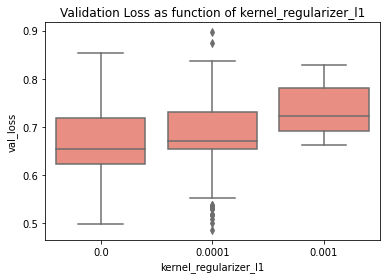

In [32]:
metric = 'kernel_regularizer_l1'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of kernel_regularizer_l2')

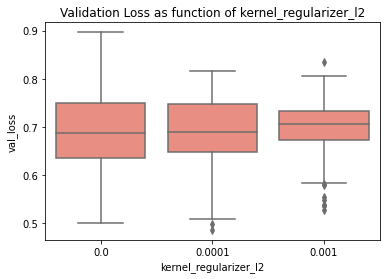

In [33]:
metric = 'kernel_regularizer_l2'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of bias_regularizer')

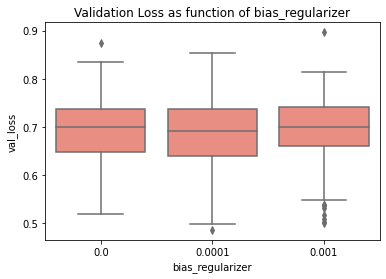

In [35]:
metric = 'bias_regularizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of activity_regularizer')

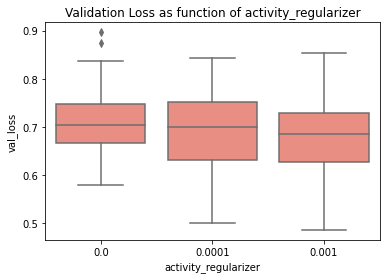

In [36]:
metric = 'activity_regularizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of dropout')

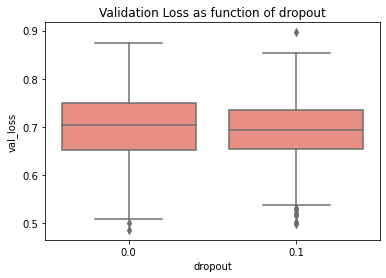

In [37]:
metric = 'dropout'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of lr')

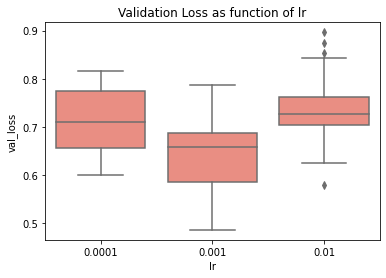

In [38]:
metric = 'lr'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

## Part 5

In [44]:
p = {
    'first_neuron':[55],  #Done
     'hidden_neuron':[50], #Done

     'hidden_layers':[2], #Done  

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [64], #Done

    'lr':[0.01,0.005,0.001,0.0005,0.0001],
    
    'kernel_regularizer_l1':[0.1,0.01,0.001,0.0001],
    'kernel_regularizer_l2':[0.1,0.01,0.001,0.0001],
    'bias_regularizer':[0.1,0.01,0.001,0.0001],
    'activity_regularizer':[0.1,0.01,0.001,0.0001],

  #  'dropout': [0,0.1,0.2,0.3,0.4],
  'dropout': [0],

  
    'kernel_initializer': ['identity'],

    'activation_layer':['tanh'],
 
    'batc_normalization':[False], #Done
 
}

In [ ]:
t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy M - Weighted binary cross-entropy (nowe)')

In [46]:
df=pd.read_csv("C:/Users/Marze/OneDrive/Dokumenty/Jarek/Magisterka/Predykcja klasy M - Weighted binary cross-entropy (nowe)/050722160303.csv", encoding="utf-8")


In [47]:
df

,round_epochs,loss,fbeta_score,precision,recall,val_loss,val_fbeta_score,val_precision,val_recall,activation_layer,...,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
0,78,1.973409,[0.],0.000000,0.000000,1.945398,[0.],0.000000,0.000000,tanh,...,0,100000,55,2,50,identity,0.1000,0.1000,sigmoid,0.0100
1,113,1.328530,[0.],0.000000,0.000000,1.306939,[0.],0.000000,0.000000,tanh,...,0,100000,55,2,50,identity,0.1000,0.1000,sigmoid,0.0050
2,353,0.837536,[0.],0.000000,0.000000,0.819942,[0.],0.000000,0.000000,tanh,...,0,100000,55,2,50,identity,0.1000,0.1000,sigmoid,0.0010
3,569,0.777718,[0.],0.000000,0.000000,0.759237,[0.],0.000000,0.000000,tanh,...,0,100000,55,2,50,identity,0.1000,0.1000,sigmoid,0.0005
4,1734,0.747680,[0.],0.000000,0.000000,0.728891,[0.],0.000000,0.000000,tanh,...,0,100000,55,2,50,identity,0.1000,0.1000,sigmoid,0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,51,0.639333,[0.3082569],0.183007,0.976744,0.706048,[0.29411766],0.175439,0.909091,tanh,...,0,100000,55,2,50,identity,0.0001,0.0001,sigmoid,0.0100
1276,60,0.616276,[0.3159851],0.188053,0.988372,0.732050,[0.2962963],0.176991,0.909091,tanh,...,0,100000,55,2,50,identity,0.0001,0.0001,sigmoid,0.0050
1277,150,0.588511,[0.34398034],0.218069,0.813953,0.613052,[0.18181817],0.272727,0.136364,tanh,...,0,100000,55,2,50,identity,0.0001,0.0001,sigmoid,0.0010
1278,245,0.544577,[0.4311377],0.290323,0.837209,0.590321,[0.34042552],0.320000,0.363636,tanh,...,0,100000,55,2,50,identity,0.0001,0.0001,sigmoid,0.0005


In [48]:
stare_wart=df['val_fbeta_score']
nowe_wart=[]
for x in stare_wart:
    wart=x.replace('[','')
    wart=wart.replace(']','')
    wart=float(wart)
    nowe_wart.append(wart)

In [49]:
df['val_fbeta_score']=nowe_wart

In [50]:
df=df.sort_values('val_loss',ascending=True)

In [51]:
df

,round_epochs,loss,fbeta_score,precision,recall,val_loss,val_fbeta_score,val_precision,val_recall,activation_layer,...,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
1032,178,0.577092,[0.41916165],0.282258,0.813953,0.532189,0.368421,0.437500,0.318182,tanh,...,0,100000,55,2,50,identity,0.0001,0.0010,sigmoid,0.0010
1118,187,0.576626,[0.43046358],0.300926,0.755814,0.549616,0.410256,0.470588,0.363636,tanh,...,0,100000,55,2,50,identity,0.0001,0.0001,sigmoid,0.0005
557,185,0.587778,[0.42682928],0.289256,0.813953,0.551359,0.187500,0.300000,0.136364,tanh,...,0,100000,55,2,50,identity,0.0001,0.0001,sigmoid,0.0010
551,158,0.634653,[0.33718243],0.210375,0.848837,0.556054,0.206897,0.428571,0.136364,tanh,...,0,100000,55,2,50,identity,0.0001,0.0010,sigmoid,0.0050
558,243,0.608775,[0.42402828],0.304569,0.697674,0.565900,0.421053,0.500000,0.363636,tanh,...,0,100000,55,2,50,identity,0.0001,0.0001,sigmoid,0.0005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205,72,2.369912,[0.26299694],0.151408,1.000000,2.624780,0.268293,0.154930,1.000000,tanh,...,0,100000,55,2,50,identity,0.1000,0.0100,sigmoid,0.0100
1120,68,2.499672,[0.26299694],0.151408,1.000000,2.698787,0.268293,0.154930,1.000000,tanh,...,0,100000,55,2,50,identity,0.1000,0.1000,sigmoid,0.0100
1040,68,2.452354,[0.22155689],0.149194,0.430233,2.699582,0.268293,0.154930,1.000000,tanh,...,0,100000,55,2,50,identity,0.1000,0.1000,sigmoid,0.0100
960,76,2.438512,[0.22077921],0.135638,0.593023,2.733719,0.268293,0.154930,1.000000,tanh,...,0,100000,55,2,50,identity,0.1000,0.1000,sigmoid,0.0100


 ## 5.1 lr

Text(0.5, 1.0, 'Validation Loss as function of lr')

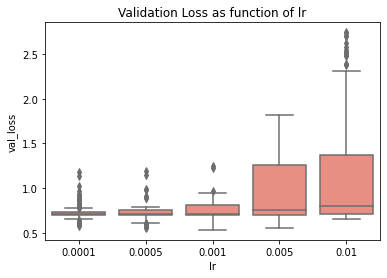

In [69]:
metric = 'lr'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

(0.4, 1.0)

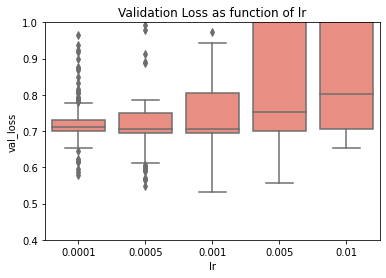

In [60]:
metric = 'lr'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')
plt.ylim(0.4, 1)

## 5.2 reg l1

Text(0.5, 1.0, 'Validation Loss as function of kernel_regularizer_l1')

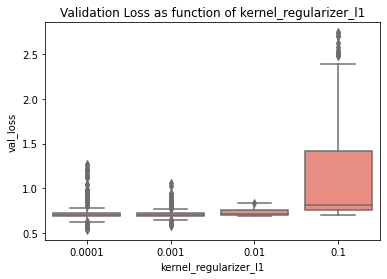

In [71]:
metric = 'kernel_regularizer_l1'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

(0.4, 1.0)

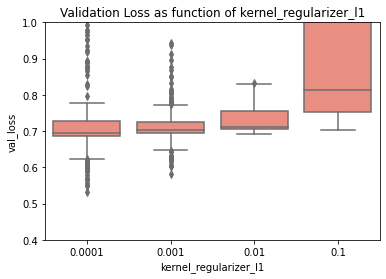

In [61]:
metric = 'kernel_regularizer_l1'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')
plt.ylim(0.4, 1)

## 5.3 reg l2

Text(0.5, 1.0, 'Validation Loss as function of kernel_regularizer_l2')

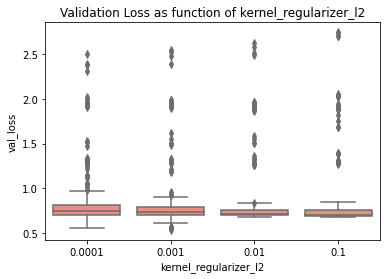

In [70]:
metric = 'kernel_regularizer_l2'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


(0.4, 1.0)

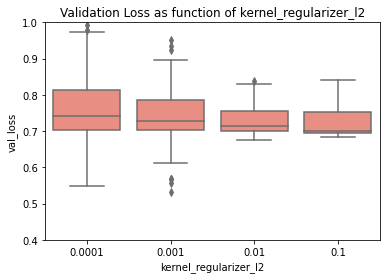

In [62]:
metric = 'kernel_regularizer_l2'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')
plt.ylim(0.4, 1)

## 5.4 bias

Text(0.5, 1.0, 'Validation Loss as function of bias_regularizer')

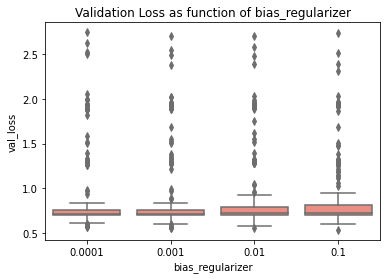

In [64]:
metric = 'bias_regularizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


(0.4, 1.0)

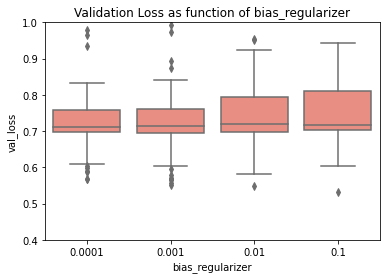

In [65]:
metric = 'bias_regularizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')
plt.ylim(0.4, 1)

## 5.5 activity

Text(0.5, 1.0, 'Validation Loss as function of activity_regularizer')

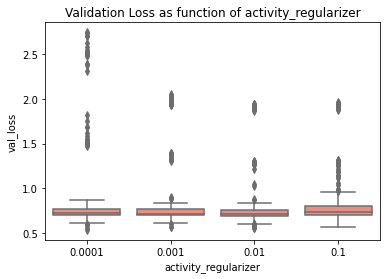

In [67]:
metric = 'activity_regularizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

(0.4, 1.0)

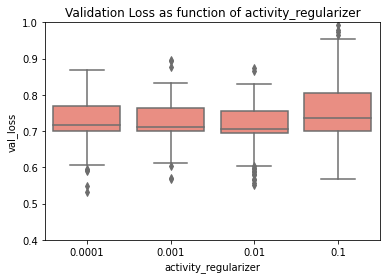

In [68]:
metric = 'activity_regularizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')
plt.ylim(0.4, 1)

## Part 6

In [73]:
p = {
    'first_neuron':[55],  #Done
     'hidden_neuron':[50], #Done

     'hidden_layers':[0,1,2],   

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [64], #Done

    'lr':[0.005,0.001],
    
    'kernel_regularizer_l1':[0.001,0.0001],
    'kernel_regularizer_l2':[0.1,0.01],
    'bias_regularizer':[0.001,0.0001],
    'activity_regularizer':[0.001],

    'dropout': [0,0.1,0.2,0.3,0.4],

    'kernel_initializer': ['identity'], #Done

    'activation_layer':['tanh'], #Done
 
    'batc_normalization':[False], #Done
 
}

In [74]:
t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy M - Weighted binary cross-entropy (nowe)')

  0%|                                                                                          | 0/240 [00:00<?, ?it/s]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 51.
Epoch 101: early stopping


  0%|▎                                                                                 | 1/240 [00:05<22:27,  5.64s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 210.
Epoch 260: early stopping


  1%|▋                                                                                 | 2/240 [00:16<34:46,  8.77s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 74.
Epoch 124: early stopping


  1%|█                                                                                 | 3/240 [00:22<30:19,  7.68s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 183.
Epoch 233: early stopping


  2%|█▎                                                                                | 4/240 [00:32<33:50,  8.60s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 76.
Epoch 126: early stopping


  2%|█▋                                                                                | 5/240 [00:39<30:06,  7.69s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 212.
Epoch 262: early stopping


  2%|██                                                                                | 6/240 [00:49<34:13,  8.77s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 37.
Epoch 87: early stopping


  3%|██▍                                                                               | 7/240 [00:54<28:52,  7.44s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 176.
Epoch 226: early stopping


  3%|██▋                                                                               | 8/240 [01:04<31:22,  8.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 46.
Epoch 96: early stopping


  4%|███                                                                               | 9/240 [01:09<27:51,  7.23s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 211.
Epoch 261: early stopping


  4%|███▍                                                                             | 10/240 [01:20<32:41,  8.53s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 70.
Epoch 120: early stopping


  5%|███▋                                                                             | 11/240 [01:27<29:46,  7.80s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 201.
Epoch 251: early stopping


  5%|████                                                                             | 12/240 [01:38<33:24,  8.79s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 56.
Epoch 106: early stopping


  5%|████▍                                                                            | 13/240 [01:43<29:38,  7.83s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 207.
Epoch 257: early stopping


  6%|████▋                                                                            | 14/240 [01:55<33:33,  8.91s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 57.
Epoch 107: early stopping


  6%|█████                                                                            | 15/240 [02:00<29:43,  7.92s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 189.
Epoch 239: early stopping


  7%|█████▍                                                                           | 16/240 [02:11<32:28,  8.70s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 84.
Epoch 134: early stopping


  7%|█████▋                                                                           | 17/240 [02:18<30:27,  8.19s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 231.
Epoch 281: early stopping


  8%|██████                                                                           | 18/240 [02:31<35:19,  9.55s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 79.
Epoch 129: early stopping


  8%|██████▍                                                                          | 19/240 [02:37<32:06,  8.72s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 201.
Epoch 251: early stopping


  8%|██████▊                                                                          | 20/240 [02:49<35:01,  9.55s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 52.
Epoch 102: early stopping


  9%|███████                                                                          | 21/240 [02:55<30:46,  8.43s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 217.
Epoch 267: early stopping


  9%|███████▍                                                                         | 22/240 [03:07<34:40,  9.54s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 74.
Epoch 124: early stopping


 10%|███████▊                                                                         | 23/240 [03:13<31:25,  8.69s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 213.
Epoch 263: early stopping


 10%|████████                                                                         | 24/240 [03:25<34:39,  9.63s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 50.
Epoch 100: early stopping


 10%|████████▍                                                                        | 25/240 [03:30<29:45,  8.30s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 209.
Epoch 259: early stopping


 11%|████████▊                                                                        | 26/240 [03:41<32:23,  9.08s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 43.
Epoch 93: early stopping


 11%|█████████                                                                        | 27/240 [03:46<27:49,  7.84s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 187.
Epoch 237: early stopping


 12%|█████████▍                                                                       | 28/240 [03:57<30:17,  8.57s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 52.
Epoch 102: early stopping


 12%|█████████▊                                                                       | 29/240 [04:02<26:38,  7.57s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 203.
Epoch 253: early stopping


 12%|██████████▏                                                                      | 30/240 [04:13<29:47,  8.51s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 62.
Epoch 112: early stopping


 13%|██████████▍                                                                      | 31/240 [04:18<26:36,  7.64s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 184.
Epoch 234: early stopping


 13%|██████████▊                                                                      | 32/240 [04:29<29:28,  8.50s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 52.
Epoch 102: early stopping


 14%|███████████▏                                                                     | 33/240 [04:35<26:35,  7.71s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 215.
Epoch 265: early stopping


 14%|███████████▍                                                                     | 34/240 [04:47<30:52,  8.99s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 49.
Epoch 99: early stopping


 15%|███████████▊                                                                     | 35/240 [04:52<27:17,  7.99s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 183.
Epoch 233: early stopping


 15%|████████████▏                                                                    | 36/240 [05:03<30:00,  8.83s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 45.
Epoch 95: early stopping


 15%|████████████▍                                                                    | 37/240 [05:08<26:24,  7.81s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 236.
Epoch 286: early stopping


 16%|████████████▊                                                                    | 38/240 [05:21<31:24,  9.33s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 47.
Epoch 97: early stopping


 16%|█████████████▏                                                                   | 39/240 [05:27<27:25,  8.19s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 173.
Epoch 223: early stopping


 17%|█████████████▌                                                                   | 40/240 [05:37<29:42,  8.91s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 59.
Epoch 109: early stopping


 17%|█████████████▊                                                                   | 41/240 [05:44<27:06,  8.17s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 222.
Epoch 272: early stopping


 18%|██████████████▏                                                                  | 42/240 [05:57<31:56,  9.68s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 42.
Epoch 92: early stopping


 18%|██████████████▌                                                                  | 43/240 [06:03<27:50,  8.48s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 202.
Epoch 252: early stopping


 18%|██████████████▊                                                                  | 44/240 [06:15<31:21,  9.60s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 46.
Epoch 96: early stopping


 19%|███████████████▏                                                                 | 45/240 [06:21<27:35,  8.49s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 228.
Epoch 278: early stopping


 19%|███████████████▌                                                                 | 46/240 [06:34<32:04,  9.92s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 62.
Epoch 112: early stopping


 20%|███████████████▊                                                                 | 47/240 [06:41<28:38,  8.91s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 180.
Epoch 230: early stopping


 20%|████████████████▏                                                                | 48/240 [06:52<30:46,  9.62s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 43.
Epoch 93: early stopping


 20%|████████████████▌                                                                | 49/240 [06:57<26:10,  8.22s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 219.
Epoch 269: early stopping


 21%|████████████████▉                                                                | 50/240 [07:08<28:55,  9.14s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 47.
Epoch 97: early stopping


 21%|█████████████████▏                                                               | 51/240 [07:15<26:14,  8.33s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 198.
Epoch 248: early stopping


 22%|█████████████████▌                                                               | 52/240 [07:25<28:08,  8.98s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 61.
Epoch 111: early stopping


 22%|█████████████████▉                                                               | 53/240 [07:31<24:47,  7.95s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 204.
Epoch 254: early stopping


 22%|██████████████████▏                                                              | 54/240 [07:41<27:17,  8.80s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 48.
Epoch 98: early stopping


 23%|██████████████████▌                                                              | 55/240 [07:46<23:41,  7.69s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 204.
Epoch 254: early stopping


 23%|██████████████████▉                                                              | 56/240 [07:57<26:38,  8.69s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 46.
Epoch 96: early stopping


 24%|███████████████████▏                                                             | 57/240 [08:03<23:36,  7.74s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 218.
Epoch 268: early stopping


 24%|███████████████████▌                                                             | 58/240 [08:15<27:31,  9.07s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 59.
Epoch 109: early stopping


 25%|███████████████████▉                                                             | 59/240 [08:21<24:34,  8.15s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 185.
Epoch 235: early stopping


 25%|████████████████████▎                                                            | 60/240 [08:32<26:49,  8.94s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 56.
Epoch 106: early stopping


 25%|████████████████████▌                                                            | 61/240 [08:38<23:54,  8.01s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 258.
Epoch 308: early stopping


 26%|████████████████████▉                                                            | 62/240 [08:51<28:46,  9.70s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 83.
Epoch 133: early stopping


 26%|█████████████████████▎                                                           | 63/240 [08:58<26:07,  8.86s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 163.
Epoch 213: early stopping


 27%|█████████████████████▌                                                           | 64/240 [09:08<26:58,  9.19s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 46.
Epoch 96: early stopping


 27%|█████████████████████▉                                                           | 65/240 [09:14<23:54,  8.20s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 218.
Epoch 268: early stopping


 28%|██████████████████████▎                                                          | 66/240 [09:27<27:53,  9.62s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 78.
Epoch 128: early stopping


 28%|██████████████████████▌                                                          | 67/240 [09:34<25:37,  8.89s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 188.
Epoch 238: early stopping


 28%|██████████████████████▉                                                          | 68/240 [09:46<28:17,  9.87s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 52.
Epoch 102: early stopping


 29%|███████████████████████▎                                                         | 69/240 [09:53<25:06,  8.81s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 224.
Epoch 274: early stopping


 29%|███████████████████████▋                                                         | 70/240 [10:06<28:38, 10.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 51.
Epoch 101: early stopping


 30%|███████████████████████▉                                                         | 71/240 [10:12<25:00,  8.88s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 196.
Epoch 246: early stopping


 30%|████████████████████████▎                                                        | 72/240 [10:24<27:21,  9.77s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 50.
Epoch 100: early stopping


 30%|████████████████████████▋                                                        | 73/240 [10:29<23:21,  8.40s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 206.
Epoch 256: early stopping


 31%|████████████████████████▉                                                        | 74/240 [10:40<25:15,  9.13s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 69.
Epoch 119: early stopping


 31%|█████████████████████████▎                                                       | 75/240 [10:46<22:21,  8.13s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 179.
Epoch 229: early stopping


 32%|█████████████████████████▋                                                       | 76/240 [10:55<23:34,  8.62s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 43.
Epoch 93: early stopping


 32%|█████████████████████████▉                                                       | 77/240 [11:00<20:25,  7.52s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 215.
Epoch 265: early stopping


 32%|██████████████████████████▎                                                      | 78/240 [11:12<23:13,  8.60s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 34.
Epoch 84: early stopping


 33%|██████████████████████████▋                                                      | 79/240 [11:16<19:52,  7.41s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 151.
Epoch 201: early stopping


 33%|███████████████████████████                                                      | 80/240 [11:25<20:50,  7.82s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 46.
Epoch 96: early stopping


 34%|███████████████████████████▎                                                     | 81/240 [11:30<18:49,  7.10s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 212.
Epoch 262: early stopping


 34%|███████████████████████████▋                                                     | 82/240 [11:42<22:25,  8.52s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 37.
Epoch 87: early stopping


 35%|████████████████████████████                                                     | 83/240 [11:47<19:36,  7.50s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 190.
Epoch 240: early stopping


 35%|████████████████████████████▎                                                    | 84/240 [11:58<22:20,  8.59s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 45.
Epoch 95: early stopping


 35%|████████████████████████████▋                                                    | 85/240 [12:04<19:45,  7.65s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 213.
Epoch 263: early stopping


 36%|█████████████████████████████                                                    | 86/240 [12:16<22:52,  8.91s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 59.
Epoch 109: early stopping


 36%|█████████████████████████████▎                                                   | 87/240 [12:22<20:27,  8.02s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 182.
Epoch 232: early stopping


 37%|█████████████████████████████▋                                                   | 88/240 [12:32<22:19,  8.82s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 51.
Epoch 101: early stopping


 37%|██████████████████████████████                                                   | 89/240 [12:38<20:05,  7.99s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 231.
Epoch 281: early stopping


 38%|██████████████████████████████▍                                                  | 90/240 [12:52<23:59,  9.59s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 51.
Epoch 101: early stopping


 38%|██████████████████████████████▋                                                  | 91/240 [12:58<21:10,  8.53s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 201.
Epoch 251: early stopping


 38%|███████████████████████████████                                                  | 92/240 [13:10<23:41,  9.61s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 46.
Epoch 96: early stopping


 39%|███████████████████████████████▍                                                 | 93/240 [13:16<20:48,  8.49s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 221.
Epoch 271: early stopping


 39%|███████████████████████████████▋                                                 | 94/240 [13:29<23:55,  9.83s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 51.
Epoch 101: early stopping


 40%|████████████████████████████████                                                 | 95/240 [13:35<21:01,  8.70s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 246.
Epoch 296: early stopping


 40%|████████████████████████████████▍                                                | 96/240 [13:49<24:40, 10.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 44.
Epoch 94: early stopping


 40%|████████████████████████████████▋                                                | 97/240 [13:54<20:44,  8.70s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 211.
Epoch 261: early stopping


 41%|█████████████████████████████████                                                | 98/240 [14:05<22:37,  9.56s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 96.
Epoch 146: early stopping


 41%|█████████████████████████████████▍                                               | 99/240 [14:12<20:31,  8.74s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 177.
Epoch 227: early stopping


 42%|█████████████████████████████████▎                                              | 100/240 [14:22<21:05,  9.04s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 82.
Epoch 132: early stopping


 42%|█████████████████████████████████▋                                              | 101/240 [14:28<19:02,  8.22s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 216.
Epoch 266: early stopping


 42%|██████████████████████████████████                                              | 102/240 [14:39<20:55,  9.10s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 45.
Epoch 95: early stopping


 43%|██████████████████████████████████▎                                             | 103/240 [14:46<18:57,  8.30s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 149.
Epoch 199: early stopping


 43%|██████████████████████████████████▋                                             | 104/240 [14:55<19:06,  8.43s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 53.
Epoch 103: early stopping


 44%|███████████████████████████████████                                             | 105/240 [15:00<17:10,  7.64s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 224.
Epoch 274: early stopping


 44%|███████████████████████████████████▎                                            | 106/240 [15:13<20:08,  9.02s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 64.
Epoch 114: early stopping


 45%|███████████████████████████████████▋                                            | 107/240 [15:19<18:03,  8.15s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 208.
Epoch 258: early stopping


 45%|████████████████████████████████████                                            | 108/240 [15:30<20:16,  9.21s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 47.
Epoch 97: early stopping


 45%|████████████████████████████████████▎                                           | 109/240 [15:36<17:42,  8.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 210.
Epoch 260: early stopping


 46%|████████████████████████████████████▋                                           | 110/240 [15:47<19:41,  9.09s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 60.
Epoch 110: early stopping


 46%|█████████████████████████████████████                                           | 111/240 [15:53<17:27,  8.12s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 175.
Epoch 225: early stopping


 47%|█████████████████████████████████████▎                                          | 112/240 [16:03<18:33,  8.70s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 48.
Epoch 98: early stopping


 47%|█████████████████████████████████████▋                                          | 113/240 [16:09<16:32,  7.82s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 233.
Epoch 283: early stopping


 48%|██████████████████████████████████████                                          | 114/240 [16:22<19:41,  9.38s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 48.
Epoch 98: early stopping


 48%|██████████████████████████████████████▎                                         | 115/240 [16:28<17:17,  8.30s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 213.
Epoch 263: early stopping


 48%|██████████████████████████████████████▋                                         | 116/240 [16:40<19:36,  9.48s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 76.
Epoch 126: early stopping


 49%|███████████████████████████████████████                                         | 117/240 [16:47<17:48,  8.69s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 224.
Epoch 274: early stopping


 49%|███████████████████████████████████████▎                                        | 118/240 [17:00<20:04,  9.88s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 78.
Epoch 128: early stopping


 50%|███████████████████████████████████████▋                                        | 119/240 [17:06<18:05,  8.97s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 204.
Epoch 254: early stopping


 50%|████████████████████████████████████████                                        | 120/240 [17:18<19:39,  9.83s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 42.
Epoch 92: early stopping


 50%|████████████████████████████████████████▎                                       | 121/240 [17:23<16:23,  8.27s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 231.
Epoch 281: early stopping


 51%|████████████████████████████████████████▋                                       | 122/240 [17:34<17:54,  9.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 38.
Epoch 88: early stopping


 51%|█████████████████████████████████████████                                       | 123/240 [17:38<15:05,  7.74s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 241.
Epoch 291: early stopping


 52%|█████████████████████████████████████████▎                                      | 124/240 [17:50<17:08,  8.87s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 44.
Epoch 94: early stopping


 52%|█████████████████████████████████████████▋                                      | 125/240 [17:55<14:35,  7.62s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 197.
Epoch 247: early stopping


 52%|██████████████████████████████████████████                                      | 126/240 [18:05<15:48,  8.32s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 98.
Epoch 148: early stopping


 53%|██████████████████████████████████████████▎                                     | 127/240 [18:11<14:38,  7.78s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 179.
Epoch 229: early stopping


 53%|██████████████████████████████████████████▋                                     | 128/240 [18:20<15:23,  8.24s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 48.
Epoch 98: early stopping


 54%|███████████████████████████████████████████                                     | 129/240 [18:26<13:30,  7.30s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 210.
Epoch 260: early stopping


 54%|███████████████████████████████████████████▎                                    | 130/240 [18:36<15:21,  8.38s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 77.
Epoch 127: early stopping


 55%|███████████████████████████████████████████▋                                    | 131/240 [18:43<13:59,  7.70s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 192.
Epoch 242: early stopping


 55%|████████████████████████████████████████████                                    | 132/240 [18:53<15:12,  8.45s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 45.
Epoch 95: early stopping


 55%|████████████████████████████████████████████▎                                   | 133/240 [18:58<13:13,  7.41s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 215.
Epoch 265: early stopping


 56%|████████████████████████████████████████████▋                                   | 134/240 [19:09<14:58,  8.48s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 77.
Epoch 127: early stopping


 56%|█████████████████████████████████████████████                                   | 135/240 [19:15<13:34,  7.76s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 167.
Epoch 217: early stopping


 57%|█████████████████████████████████████████████▎                                  | 136/240 [19:24<14:13,  8.20s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 49.
Epoch 99: early stopping


 57%|█████████████████████████████████████████████▋                                  | 137/240 [19:29<12:38,  7.37s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 223.
Epoch 273: early stopping


 57%|██████████████████████████████████████████████                                  | 138/240 [19:41<14:48,  8.71s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 87.
Epoch 137: early stopping


 58%|██████████████████████████████████████████████▎                                 | 139/240 [19:48<13:42,  8.14s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 193.
Epoch 243: early stopping


 58%|██████████████████████████████████████████████▋                                 | 140/240 [19:59<14:56,  8.96s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 51.
Epoch 101: early stopping


 59%|███████████████████████████████████████████████                                 | 141/240 [20:05<13:05,  7.93s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 224.
Epoch 274: early stopping


 59%|███████████████████████████████████████████████▎                                | 142/240 [20:16<14:50,  9.09s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 49.
Epoch 99: early stopping


 60%|███████████████████████████████████████████████▋                                | 143/240 [20:22<12:55,  7.99s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 183.
Epoch 233: early stopping


 60%|████████████████████████████████████████████████                                | 144/240 [20:32<13:55,  8.71s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 52.
Epoch 102: early stopping


 60%|████████████████████████████████████████████████▎                               | 145/240 [20:37<12:03,  7.62s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 218.
Epoch 268: early stopping


 61%|████████████████████████████████████████████████▋                               | 146/240 [20:48<13:26,  8.58s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 80.
Epoch 130: early stopping


 61%|█████████████████████████████████████████████████                               | 147/240 [20:54<12:05,  7.81s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 170.
Epoch 220: early stopping


 62%|█████████████████████████████████████████████████▎                              | 148/240 [21:03<12:37,  8.23s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 59.
Epoch 109: early stopping


 62%|█████████████████████████████████████████████████▋                              | 149/240 [21:09<11:08,  7.35s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 209.
Epoch 259: early stopping


 62%|██████████████████████████████████████████████████                              | 150/240 [21:19<12:27,  8.31s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 37.
Epoch 87: early stopping


 63%|██████████████████████████████████████████████████▎                             | 151/240 [21:24<10:39,  7.18s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 172.
Epoch 222: early stopping


 63%|██████████████████████████████████████████████████▋                             | 152/240 [21:33<11:26,  7.81s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 60.
Epoch 110: early stopping


 64%|███████████████████████████████████████████████████                             | 153/240 [21:39<10:26,  7.20s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 244.
Epoch 294: early stopping


 64%|███████████████████████████████████████████████████▎                            | 154/240 [21:51<12:38,  8.82s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 39.
Epoch 89: early stopping


 65%|███████████████████████████████████████████████████▋                            | 155/240 [21:56<10:52,  7.68s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 204.
Epoch 254: early stopping


 65%|████████████████████████████████████████████████████                            | 156/240 [22:07<12:13,  8.73s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 45.
Epoch 95: early stopping


 65%|████████████████████████████████████████████████████▎                           | 157/240 [22:13<10:38,  7.70s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 217.
Epoch 267: early stopping


 66%|████████████████████████████████████████████████████▋                           | 158/240 [22:24<12:07,  8.87s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 67.
Epoch 117: early stopping


 66%|█████████████████████████████████████████████████████                           | 159/240 [22:30<10:49,  8.01s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 184.
Epoch 234: early stopping


 67%|█████████████████████████████████████████████████████▎                          | 160/240 [22:41<11:36,  8.71s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 46.
Epoch 96: early stopping


 67%|█████████████████████████████████████████████████████▋                          | 161/240 [22:46<10:14,  7.78s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 218.
Epoch 268: early stopping


 68%|██████████████████████████████████████████████████████                          | 162/240 [23:08<15:41, 12.07s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 39.
Epoch 89: early stopping


 68%|██████████████████████████████████████████████████████▎                         | 163/240 [23:14<12:54, 10.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 237.
Epoch 287: early stopping


 68%|██████████████████████████████████████████████████████▋                         | 164/240 [23:27<13:53, 10.96s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 47.
Epoch 97: early stopping


 69%|███████████████████████████████████████████████████████                         | 165/240 [23:33<11:43,  9.38s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 217.
Epoch 267: early stopping


 69%|███████████████████████████████████████████████████████▎                        | 166/240 [23:45<12:39, 10.27s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 85.
Epoch 135: early stopping


 70%|███████████████████████████████████████████████████████▋                        | 167/240 [23:52<11:21,  9.34s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 211.
Epoch 261: early stopping


 70%|████████████████████████████████████████████████████████                        | 168/240 [24:04<12:12, 10.18s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 43.
Epoch 93: early stopping


 70%|████████████████████████████████████████████████████████▎                       | 169/240 [24:09<10:07,  8.56s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 209.
Epoch 259: early stopping


 71%|████████████████████████████████████████████████████████▋                       | 170/240 [24:20<10:40,  9.16s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 50.
Epoch 100: early stopping


 71%|█████████████████████████████████████████████████████████                       | 171/240 [24:25<09:06,  7.92s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 193.
Epoch 243: early stopping


 72%|█████████████████████████████████████████████████████████▎                      | 172/240 [24:34<09:39,  8.52s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 47.
Epoch 97: early stopping


 72%|█████████████████████████████████████████████████████████▋                      | 173/240 [24:41<08:43,  7.82s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 224.
Epoch 274: early stopping


 72%|██████████████████████████████████████████████████████████                      | 174/240 [24:52<09:51,  8.97s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 80.
Epoch 130: early stopping


 73%|██████████████████████████████████████████████████████████▎                     | 175/240 [24:58<08:45,  8.09s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 247.
Epoch 297: early stopping


 73%|██████████████████████████████████████████████████████████▋                     | 176/240 [25:10<09:49,  9.21s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 46.
Epoch 96: early stopping


 74%|███████████████████████████████████████████████████████████                     | 177/240 [25:15<08:25,  8.02s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 210.
Epoch 260: early stopping


 74%|███████████████████████████████████████████████████████████▎                    | 178/240 [25:27<09:18,  9.01s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 52.
Epoch 102: early stopping


 75%|███████████████████████████████████████████████████████████▋                    | 179/240 [25:32<08:04,  7.95s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 198.
Epoch 248: early stopping


 75%|████████████████████████████████████████████████████████████                    | 180/240 [25:43<08:50,  8.84s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 51.
Epoch 101: early stopping


 75%|████████████████████████████████████████████████████████████▎                   | 181/240 [25:49<07:41,  7.81s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 209.
Epoch 259: early stopping


 76%|████████████████████████████████████████████████████████████▋                   | 182/240 [26:00<08:34,  8.88s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 64.
Epoch 114: early stopping


 76%|█████████████████████████████████████████████████████████████                   | 183/240 [26:06<07:38,  8.04s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 194.
Epoch 244: early stopping


 77%|█████████████████████████████████████████████████████████████▎                  | 184/240 [26:17<08:14,  8.84s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 75.
Epoch 125: early stopping


 77%|█████████████████████████████████████████████████████████████▋                  | 185/240 [26:23<07:32,  8.22s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 259.
Epoch 309: early stopping


 78%|██████████████████████████████████████████████████████████████                  | 186/240 [26:37<08:56,  9.94s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 48.
Epoch 98: early stopping


 78%|██████████████████████████████████████████████████████████████▎                 | 187/240 [26:43<07:39,  8.66s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 243.
Epoch 293: early stopping


 78%|██████████████████████████████████████████████████████████████▋                 | 188/240 [26:56<08:42, 10.04s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 62.
Epoch 112: early stopping


 79%|███████████████████████████████████████████████████████████████                 | 189/240 [27:03<07:34,  8.92s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 235.
Epoch 285: early stopping


 79%|███████████████████████████████████████████████████████████████▎                | 190/240 [27:16<08:28, 10.17s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 85.
Epoch 135: early stopping


 80%|███████████████████████████████████████████████████████████████▋                | 191/240 [27:23<07:33,  9.25s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 239.
Epoch 289: early stopping


 80%|████████████████████████████████████████████████████████████████                | 192/240 [27:36<08:26, 10.55s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 47.
Epoch 97: early stopping


 80%|████████████████████████████████████████████████████████████████▎               | 193/240 [27:41<06:56,  8.87s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 229.
Epoch 279: early stopping


 81%|████████████████████████████████████████████████████████████████▋               | 194/240 [27:53<07:21,  9.59s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 152.
Epoch 202: early stopping


 81%|█████████████████████████████████████████████████████████████████               | 195/240 [28:01<06:56,  9.26s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 152.
Epoch 202: early stopping


 82%|█████████████████████████████████████████████████████████████████▎              | 196/240 [28:10<06:39,  9.08s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 42.
Epoch 92: early stopping


 82%|█████████████████████████████████████████████████████████████████▋              | 197/240 [28:15<05:34,  7.77s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 224.
Epoch 274: early stopping


 82%|██████████████████████████████████████████████████████████████████              | 198/240 [28:26<06:08,  8.77s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 30.
Epoch 80: early stopping


 83%|██████████████████████████████████████████████████████████████████▎             | 199/240 [28:30<05:04,  7.43s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 155.
Epoch 205: early stopping


 83%|██████████████████████████████████████████████████████████████████▋             | 200/240 [28:39<05:11,  7.80s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 53.
Epoch 103: early stopping


 84%|███████████████████████████████████████████████████████████████████             | 201/240 [28:44<04:37,  7.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 247.
Epoch 297: early stopping


 84%|███████████████████████████████████████████████████████████████████▎            | 202/240 [28:57<05:33,  8.79s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 42.
Epoch 92: early stopping


 85%|███████████████████████████████████████████████████████████████████▋            | 203/240 [29:02<04:44,  7.68s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 182.
Epoch 232: early stopping


 85%|████████████████████████████████████████████████████████████████████            | 204/240 [29:12<05:04,  8.47s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 45.
Epoch 95: early stopping


 85%|████████████████████████████████████████████████████████████████████▎           | 205/240 [29:17<04:22,  7.49s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 210.
Epoch 260: early stopping


 86%|████████████████████████████████████████████████████████████████████▋           | 206/240 [29:29<04:53,  8.63s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 58.
Epoch 108: early stopping


 86%|█████████████████████████████████████████████████████████████████████           | 207/240 [29:34<04:15,  7.74s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 174.
Epoch 224: early stopping


 87%|█████████████████████████████████████████████████████████████████████▎          | 208/240 [29:44<04:29,  8.41s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 49.
Epoch 99: early stopping


 87%|█████████████████████████████████████████████████████████████████████▋          | 209/240 [29:50<03:55,  7.61s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 219.
Epoch 269: early stopping


 88%|██████████████████████████████████████████████████████████████████████          | 210/240 [30:02<04:31,  9.04s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 52.
Epoch 102: early stopping


 88%|██████████████████████████████████████████████████████████████████████▎         | 211/240 [30:08<03:54,  8.10s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 190.
Epoch 240: early stopping


 88%|██████████████████████████████████████████████████████████████████████▋         | 212/240 [30:20<04:13,  9.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 46.
Epoch 96: early stopping


 89%|███████████████████████████████████████████████████████████████████████         | 213/240 [30:25<03:36,  8.03s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 225.
Epoch 275: early stopping


 89%|███████████████████████████████████████████████████████████████████████▎        | 214/240 [30:38<04:04,  9.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 49.
Epoch 99: early stopping


 90%|███████████████████████████████████████████████████████████████████████▋        | 215/240 [30:44<03:27,  8.31s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 210.
Epoch 260: early stopping


 90%|████████████████████████████████████████████████████████████████████████        | 216/240 [30:56<03:46,  9.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 65.
Epoch 115: early stopping


 90%|████████████████████████████████████████████████████████████████████████▎       | 217/240 [31:01<03:09,  8.24s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 217.
Epoch 267: early stopping


 91%|████████████████████████████████████████████████████████████████████████▋       | 218/240 [31:12<03:18,  9.00s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 41.
Epoch 91: early stopping


 91%|█████████████████████████████████████████████████████████████████████████       | 219/240 [31:17<02:41,  7.70s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 158.
Epoch 208: early stopping


 92%|█████████████████████████████████████████████████████████████████████████▎      | 220/240 [31:25<02:39,  8.00s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 44.
Epoch 94: early stopping


 92%|█████████████████████████████████████████████████████████████████████████▋      | 221/240 [31:30<02:13,  7.03s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 211.
Epoch 261: early stopping


 92%|██████████████████████████████████████████████████████████████████████████      | 222/240 [31:41<02:25,  8.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
Restoring model weights from the end of the best epoch: 86.
Epoch 136: early stopping


 93%|██████████████████████████████████████████████████████████████████████████▎     | 223/240 [31:47<02:08,  7.54s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 184.
Epoch 234: early stopping


 93%|██████████████████████████████████████████████████████████████████████████▋     | 224/240 [31:57<02:10,  8.16s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 46.
Epoch 96: early stopping


 94%|███████████████████████████████████████████████████████████████████████████     | 225/240 [32:02<01:49,  7.29s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 215.
Epoch 265: early stopping


 94%|███████████████████████████████████████████████████████████████████████████▎    | 226/240 [32:13<02:00,  8.58s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 42.
Epoch 92: early stopping


 95%|███████████████████████████████████████████████████████████████████████████▋    | 227/240 [32:18<01:37,  7.53s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 174.
Epoch 224: early stopping


 95%|████████████████████████████████████████████████████████████████████████████    | 228/240 [32:28<01:38,  8.24s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 46.
Epoch 96: early stopping


 95%|████████████████████████████████████████████████████████████████████████████▎   | 229/240 [32:34<01:20,  7.34s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 215.
Epoch 265: early stopping


 96%|████████████████████████████████████████████████████████████████████████████▋   | 230/240 [32:45<01:25,  8.57s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
Restoring model weights from the end of the best epoch: 40.
Epoch 90: early stopping


 96%|█████████████████████████████████████████████████████████████████████████████   | 231/240 [32:50<01:07,  7.51s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
Restoring model weights from the end of the best epoch: 216.
Epoch 266: early stopping


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 232/240 [33:02<01:09,  8.69s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 61.
Epoch 111: early stopping


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 233/240 [33:08<00:55,  7.95s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 221.
Epoch 271: early stopping


 98%|██████████████████████████████████████████████████████████████████████████████  | 234/240 [33:20<00:55,  9.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 59.
Epoch 109: early stopping


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 235/240 [33:26<00:41,  8.34s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 203.
Epoch 253: early stopping


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 236/240 [33:38<00:37,  9.34s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 50.
Epoch 100: early stopping


 99%|███████████████████████████████████████████████████████████████████████████████ | 237/240 [33:44<00:24,  8.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 222.
Epoch 272: early stopping


 99%|███████████████████████████████████████████████████████████████████████████████▎| 238/240 [33:56<00:19,  9.57s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.005}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 55.
Epoch 105: early stopping


100%|███████████████████████████████████████████████████████████████████████████████▋| 239/240 [34:02<00:08,  8.49s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 2, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
Restoring model weights from the end of the best epoch: 188.
Epoch 238: early stopping


100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [34:13<00:00,  8.56s/it]


In [75]:
df=pd.read_csv("C:/Users/Marze/OneDrive/Dokumenty/Jarek/Magisterka/Predykcja klasy M - Weighted binary cross-entropy (nowe)/050822123005.csv", encoding="utf-8")

In [76]:
stare_wart=df['val_fbeta_score']
nowe_wart=[]
for x in stare_wart:
    wart=x.replace('[','')
    wart=wart.replace(']','')
    wart=float(wart)
    nowe_wart.append(wart)
df['val_fbeta_score']=nowe_wart
df=df.sort_values('val_loss',ascending=True)

In [86]:
df

,round_epochs,loss,fbeta_score,precision,recall,val_loss,val_fbeta_score,val_precision,val_recall,activation_layer,...,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
30,112,0.656584,[0.26544625],0.165242,0.674419,0.650931,0.380952,0.400000,0.363636,tanh,...,0.1,100000,55,0,50,identity,0.0001,0.01,sigmoid,0.005
158,117,0.677076,[0.24343675],0.153153,0.593023,0.671463,0.268908,0.164948,0.727273,tanh,...,0.1,100000,55,1,50,identity,0.0001,0.01,sigmoid,0.005
123,291,0.654362,[0.3153989],0.187638,0.988372,0.673656,0.303030,0.181818,0.909091,tanh,...,0.0,100000,55,0,50,identity,0.0010,0.01,sigmoid,0.001
222,136,0.689072,[0.25887266],0.157761,0.720930,0.674600,0.313433,0.187500,0.954545,tanh,...,0.4,100000,55,0,50,identity,0.0001,0.01,sigmoid,0.005
7,226,0.652959,[0.30965394],0.183585,0.988372,0.675887,0.303030,0.181818,0.909091,tanh,...,0.0,100000,55,0,50,identity,0.0001,0.01,sigmoid,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,238,0.692230,[0.3016158],0.178344,0.976744,0.712019,0.291971,0.173913,0.909091,tanh,...,0.4,100000,55,2,50,identity,0.0001,0.01,sigmoid,0.001
226,92,0.707267,[0.27096772],0.166227,0.732558,0.713894,0.281879,0.165354,0.954545,tanh,...,0.4,100000,55,1,50,identity,0.0010,0.01,sigmoid,0.005
166,135,0.685124,[0.2851782],0.170022,0.883721,0.714279,0.291971,0.173913,0.909091,tanh,...,0.1,100000,55,2,50,identity,0.0001,0.01,sigmoid,0.005
95,296,0.687659,[0.3076923],0.182609,0.976744,0.715451,0.291971,0.173913,0.909091,tanh,...,0.3,100000,55,2,50,identity,0.0001,0.01,sigmoid,0.001


Text(0.5, 1.0, 'Validation Loss as function of hidden_layers')

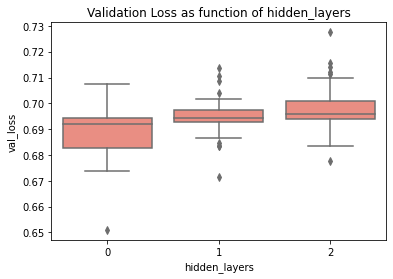

In [77]:
metric = 'hidden_layers'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of lr')

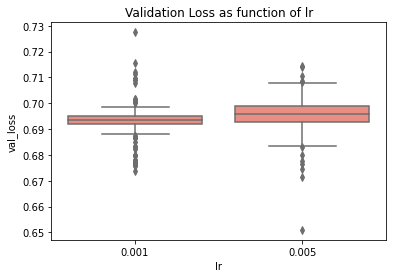

In [78]:
metric = 'lr'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of kernel_regularizer_l1')

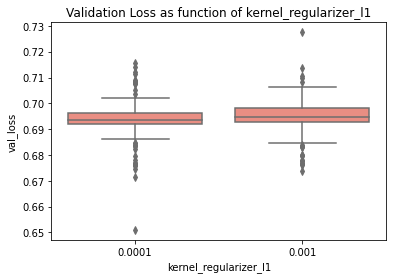

In [79]:
metric = 'kernel_regularizer_l1'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of kernel_regularizer_l2')

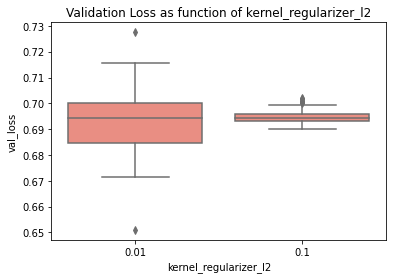

In [80]:
metric = 'kernel_regularizer_l2'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of bias_regularizer')

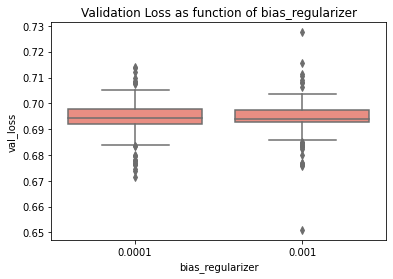

In [81]:
metric = 'bias_regularizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of dropout')

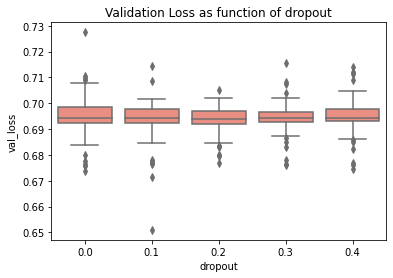

In [83]:
metric = 'dropout'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

## Part 5

In [84]:
p = {
    'first_neuron':[55],  #Done
     'hidden_neuron':[50], #Done

     'hidden_layers':[0],   

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [64], #Done

    'lr':[0.0001,0.001],
    
    'kernel_regularizer_l1':[0.0001],
    'kernel_regularizer_l2':[0.01],
    'bias_regularizer':[0.001],
    'activity_regularizer':[0.001],

    'dropout': [0,0.1,0.2,0.3,0.4],

    'kernel_initializer': ['identity'], #Done

    'activation_layer':['tanh'], #Done
 
    'batc_normalization':[False], #Done
 
}

In [87]:
t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy M - Weighted binary cross-entropy (nowe)')



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.0001}
Restoring model weights from the end of the best epoch: 861.
Epoch 911: early stopping


  0%|                                                                                      | 0/6250 [21:34:44<?, ?it/s]


 10%|████████▎                                                                          | 1/10 [00:42<06:20, 42.27s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 191.
Epoch 241: early stopping




 20%|████████████████▌                                                                  | 2/10 [00:53<03:12, 24.09s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.0001}
Restoring model weights from the end of the best epoch: 991.
Epoch 1041: early stopping




 30%|████████████████████████▉                                                          | 3/10 [01:38<03:53, 33.37s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 165.
Epoch 215: early stopping




 40%|█████████████████████████████████▏                                                 | 4/10 [01:48<02:27, 24.51s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.0001}
Restoring model weights from the end of the best epoch: 895.
Epoch 945: early stopping




 50%|█████████████████████████████████████████▌                                         | 5/10 [02:34<02:41, 32.26s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 155.
Epoch 205: early stopping




 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:45<01:38, 24.73s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.0001}
Restoring model weights from the end of the best epoch: 815.
Epoch 865: early stopping




 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:22<01:26, 28.92s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 167.
Epoch 217: early stopping




 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:33<00:46, 23.08s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.0001}
Restoring model weights from the end of the best epoch: 885.
Epoch 935: early stopping




 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:13<00:28, 28.43s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 0, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'last_activation': 'sigmoid', 'lr': 0.001}
Restoring model weights from the end of the best epoch: 166.
Epoch 216: early stopping




100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:23<00:00, 26.39s/it]


In [2]:
df=pd.read_csv("D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/M/Predykcja klasy M - podejscie z Focal-loss (nowe)/050822133608.csv", encoding="utf-8")

In [3]:
stare_wart=df['val_fbeta_score']
nowe_wart=[]
for x in stare_wart:
    wart=x.replace('[','')
    wart=wart.replace(']','')
    wart=float(wart)
    nowe_wart.append(wart)
df['val_fbeta_score']=nowe_wart
df=df.sort_values('val_loss',ascending=True)

In [4]:
df

,round_epochs,loss,fbeta_score,precision,recall,val_loss,val_fbeta_score,val_precision,val_recall,activation_layer,...,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
1,241,0.651360,[0.30965394],0.183585,0.988372,0.667851,0.304000,0.184466,0.863636,tanh,...,0.0,100000,55,0,50,identity,0.0001,0.01,sigmoid,0.0010
9,216,0.654363,[0.31758034],0.189616,0.976744,0.669149,0.310078,0.186916,0.909091,tanh,...,0.4,100000,55,0,50,identity,0.0001,0.01,sigmoid,0.0010
5,205,0.655579,[0.3082569],0.183007,0.976744,0.675522,0.303030,0.181818,0.909091,tanh,...,0.2,100000,55,0,50,identity,0.0001,0.01,sigmoid,0.0010
3,215,0.653905,[0.3145631],0.188811,0.941860,0.676960,0.296296,0.176991,0.909091,tanh,...,0.1,100000,55,0,50,identity,0.0001,0.01,sigmoid,0.0010
7,217,0.655860,[0.30601093],0.181425,0.976744,0.677174,0.300752,0.180180,0.909091,tanh,...,0.3,100000,55,0,50,identity,0.0001,0.01,sigmoid,0.0010
2,1041,0.676652,[0.3113553],0.184783,0.988372,0.698442,0.296296,0.176991,0.909091,tanh,...,0.1,100000,55,0,50,identity,0.0001,0.01,sigmoid,0.0001
4,945,0.694485,[0.3159851],0.188053,0.988372,0.711898,0.298507,0.178571,0.909091,tanh,...,0.2,100000,55,0,50,identity,0.0001,0.01,sigmoid,0.0001
8,935,0.699515,[0.310219],0.183983,0.988372,0.712790,0.298507,0.178571,0.909091,tanh,...,0.4,100000,55,0,50,identity,0.0001,0.01,sigmoid,0.0001
0,911,0.699801,[0.30965394],0.183585,0.988372,0.721145,0.296296,0.176991,0.909091,tanh,...,0.0,100000,55,0,50,identity,0.0001,0.01,sigmoid,0.0001
6,865,0.711871,[0.3108614],0.185268,0.965116,0.725317,0.307692,0.185185,0.909091,tanh,...,0.3,100000,55,0,50,identity,0.0001,0.01,sigmoid,0.0001


Text(0.5, 1.0, 'Validation Loss as function of lr')

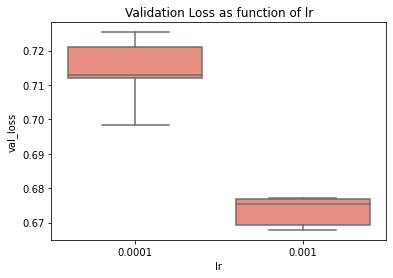

In [5]:
metric = 'lr'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of dropout')

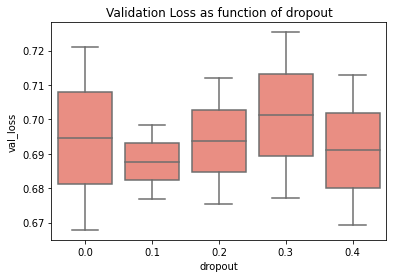

In [6]:
metric = 'dropout'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

In [ ]:
p = {
    'first_neuron':[55],  #Done
     'hidden_neuron':[50], #Done

     'hidden_layers':[0],   

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [64], #Done

    'lr':[0.001], #Done
    
    'kernel_regularizer_l1':[0.0001],#Done
    'kernel_regularizer_l2':[0.01],#Done
    'bias_regularizer':[0.001],#Done
    'activity_regularizer':[0.001],#Done

    'dropout': [0.1], #Done

    'kernel_initializer': ['identity'], #Done

    'activation_layer':['tanh'], #Done
 
    'batc_normalization':[False], #Done
 
}